In [1]:
#Function to generate a 3-panel plot for input arrays
def plot_array(dem, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None):
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,5))
    alpha = 1.0
    #Gray background
    ax.set_facecolor('0.5')
    #Force aspect ratio to match images
    ax.set(aspect='equal')
    #Turn off axes labels/ticks
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if titles is not None:
        ax.set_title(titles[0])
    #Plot background shaded relief map
    if overlay is not None:
        alpha = 0.7
        ax.imshow(overlay, cmap='gray', clim=(1,255))
    #Plot each array
    im_list = [ax.imshow(dem, clim=clim, cmap=cmap, alpha=alpha)]
    fig.tight_layout()
    fig.colorbar(im_list[0], label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)

#Function to generate a 3-panel plot for input arrays
def plot2panel(dem_list, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None):
    fig, axa = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
    alpha = 1.0
    for n, ax in enumerate(axa):
        #Gray background
        ax.set_facecolor('0.5')
        #Force aspect ratio to match images
        ax.set(aspect='equal')
        #Turn off axes labels/ticks
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if titles is not None:
            ax.set_title(titles[n])
        #Plot background shaded relief map
        if overlay is not None:
            alpha = 0.7
            axa[n].imshow(overlay[n], cmap='gray', clim=(1,255))
    #Plot each array
    im_list = [axa[i].imshow(dem_list[i], clim=clim, cmap=cmap, alpha=alpha) for i in range(len(dem_list))]
    fig.tight_layout()
    fig.colorbar(im_list[0], ax=axa.ravel().tolist(), label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)


In [2]:
#! /usr/bin/env python
"""
Compute emergence velocities for input DEMs, surface velocities and glacier polygons
"""

import sys
import os
import re
import subprocess
from datetime import datetime, timedelta
import time
import pickle
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from osgeo import gdal, ogr, osr

from pygeotools.lib import malib, warplib, geolib, iolib, timelib
# from imview.lib import pltlib

#Avoid printing out divide by 0 errors
np.seterr(all='ignore')

"""
Class to store relevant feature attributes and derived values
Safe for multiprocessing
"""
class GlacFeat:
    def __init__(self, feat, glacname_fieldname, glacnum_fieldname):

        self.glacname = feat.GetField(glacname_fieldname)
        if self.glacname is None:
            self.glacname = ""
        else:
            #RGI has some nonstandard characters
            #self.glacname = self.glacname.decode('unicode_escape').encode('ascii','ignore')
            #glacname = re.sub(r'[^\x00-\x7f]',r'', glacname)
            self.glacname = re.sub(r'\W+', '', self.glacname)
            self.glacname = self.glacname.replace(" ", "")
            self.glacname = self.glacname.replace("_", "")
            self.glacname = self.glacname.replace("/", "")

        self.glacnum = feat.GetField(glacnum_fieldname)
        fn = feat.GetDefnRef().GetName()
        #RGIId (String) = RGI50-01.00004
        self.glacnum = '%0.5f' % float(self.glacnum.split('-')[-1])

        if self.glacname:
            self.feat_fn = "%s_%s" % (self.glacnum, self.glacname)
        else:
            self.feat_fn = str(self.glacnum)

        self.glac_geom_orig = geolib.geom_dup(feat.GetGeometryRef())
        self.glac_geom = geolib.geom_dup(self.glac_geom_orig)
        #Hack to deal with fact that this is not preserved in geom when loaded from pickle on disk
        self.glac_geom_srs_wkt = self.glac_geom.GetSpatialReference().ExportToWkt()

        #Attributes written by mb_calc
        self.z1 = None
        self.z1_hs = None
        self.z1_stats = None
        self.z1_ela = None
        self.z2 = None
        self.z2_hs = None
        self.z2_stats = None
        self.z2_ela = None
        self.z2_aspect = None
        self.z2_aspect_stats = None
        self.z2_slope = None
        self.z2_slope_stats = None
        self.res = None
        self.dhdt = None
        self.mb = None
        self.mb_mean = None
        self.t1 = None
        self.t2 = None
        self.dt = None
        self.t1_mean = None
        self.t2_mean = None
        self.dt_mean = None

        self.H = None
        self.H_mean = np.nan
        self.vx = None
        self.vy = None
        self.vm = None
        self.vm_mean = np.nan
        self.divQ = None
        self.debris_class = None
        self.debris_thick = None
        self.debris_thick_mean = np.nan
        self.perc_clean = np.nan
        self.perc_debris = np.nan
        self.perc_pond = np.nan

    def geom_srs_update(self, srs=None):
        if self.glac_geom.GetSpatialReference() is None:
            if srs is None:
                srs = osr.SpatialReference()
                srs.ImportFromWkt(self.glac_geom_srs_wkt)
            self.glac_geom.AssignSpatialReference(srs)

    def geom_attributes(self, srs=None):
        self.geom_srs_update()
        if srs is not None:
            #Should reproject here to equal area, before geom_attributes
            #self.glac_geom.AssignSpatialReference(glac_shp_srs)
            #self.glac_geom_local = geolib.geom2localortho(self.glac_geom)
            geolib.geom_transform(self.glac_geom, srs)

        self.glac_geom_extent = geolib.geom_extent(self.glac_geom)
        self.glac_area = self.glac_geom.GetArea()
        self.glac_area_km2 = self.glac_area / 1E6
        self.cx, self.cy = self.glac_geom.Centroid().GetPoint_2D()

#RGI uses 50 m bins
def hist_plot(gf, outdir, bin_width=50.0, dz_clim=(-2.0, 2.0)):
    #print("Generating histograms")
    #Create bins for full range of input data and specified bin width

    #NOTE: these counts/areas are for valid pixels only
    #Not necessarily a true representation of actual glacier hypsometry
    #Need a void-filled DEM for this

    z_bin_edges, z_bin_centers = malib.get_bins(gf.z1, bin_width)
    #Need to compress here, otherwise histogram uses masked values!
    z1_bin_counts, z1_bin_edges = np.histogram(gf.z1.compressed(), bins=z_bin_edges)
    z1_bin_areas = z1_bin_counts * gf.res[0] * gf.res[1] / 1E6
    #RGI standard is integer thousandths of glaciers total area
    #Should check to make sure sum of bin areas equals total area
    #z1_bin_areas_perc = 100. * z1_bin_areas / np.sum(z1_bin_areas)
    z1_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)

    #If we only have one elevation grid with dhdt
    if gf.z2 is not None:
        z2_bin_counts, z2_bin_edges = np.histogram(gf.z2.compressed(), bins=z_bin_edges)
        z2_bin_areas = z2_bin_counts * gf.res[0] * gf.res[1] / 1E6
        #z2_bin_areas_perc = 100. * z2_bin_areas / np.sum(z2_bin_areas)
        z2_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)
    else:
        z2_bin_counts = z1_bin_counts
        z2_bin_edges = z1_bin_edges
        z2_bin_areas = z1_bin_areas
        z2_bin_areas_perc = z1_bin_areas_perc

    #Create arrays to store output
    slope_bin_med = np.ma.masked_all_like(z1_bin_areas)
    slope_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_med = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.dhdt is not None:
        mb_bin_med = np.ma.masked_all_like(z1_bin_areas)
        np.ma.set_fill_value(mb_bin_med, np.nan)
        mb_bin_mad = np.ma.masked_all_like(mb_bin_med)
        mb_bin_mean = np.ma.masked_all_like(mb_bin_med)
        mb_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_med = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mad = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mean = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_count = np.ma.masked_all_like(mb_bin_med)
    if gf.vm is not None:
        vm_bin_med = np.ma.masked_all_like(z1_bin_areas)
        vm_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.H is not None:
        H_bin_mean = np.ma.masked_all_like(z1_bin_areas)
        H_bin_std = np.ma.masked_all_like(z1_bin_areas)
#         emvel_bin_mean = np.ma.masked_all_like(z1_bin_areas)
#         emvel_bin_std = np.ma.masked_all_like(z1_bin_areas)
    if gf.debris_class is not None:
#         perc_clean = np.ma.masked_all_like(z1_bin_areas)
#         perc_debris = np.ma.masked_all_like(z1_bin_areas)
#         perc_pond = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_med = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_mad = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_clean_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_debris_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_pond_bin_med = np.ma.masked_all_like(mz1_bin_areas)

#         gf.dhdt_clean = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 1).data))
#         gf.dhdt_debris = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 2).data))
#         gf.dhdt_pond = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 3).data))

    #Bin sample count must be greater than this value
    min_bin_samp_count = 9

    #Loop through each bin and extract stats
    idx = np.digitize(gf.z1, z_bin_edges)
    for bin_n in range(z_bin_centers.size):
        if gf.dhdt is not None:
            mb_bin_samp = gf.mb_map[(idx == bin_n+1)]
            if mb_bin_samp.count() > min_bin_samp_count:
                mb_bin_med[bin_n] = malib.fast_median(mb_bin_samp)
                mb_bin_mad[bin_n] = malib.mad(mb_bin_samp)
                mb_bin_mean[bin_n] = mb_bin_samp.mean()
                mb_bin_std[bin_n] = mb_bin_samp.std()
            dhdt_bin_samp = gf.dhdt[(idx == bin_n+1)]
            if dhdt_bin_samp.count() > min_bin_samp_count:
                dhdt_bin_med[bin_n] = malib.fast_median(dhdt_bin_samp)
                dhdt_bin_mad[bin_n] = malib.mad(dhdt_bin_samp)
                dhdt_bin_mean[bin_n] = dhdt_bin_samp.mean()
                dhdt_bin_std[bin_n] = dhdt_bin_samp.std()
                dhdt_bin_count[bin_n] = dhdt_bin_samp.count()
        if gf.debris_thick is not None:
            debris_thick_bin_samp = gf.debris_thick[(idx == bin_n+1)]
            if debris_thick_bin_samp.size > min_bin_samp_count:
                debris_thick_med[bin_n] = malib.fast_median(debris_thick_bin_samp)
                debris_thick_mad[bin_n] = malib.mad(debris_thick_bin_samp)
        if gf.debris_class is not None:
            debris_class_bin_samp = gf.debris_class[(idx == bin_n+1)]
            dhdt_clean_bin_samp = gf.dhdt_clean[(idx == bin_n+1)]
            dhdt_debris_bin_samp = gf.dhdt_debris[(idx == bin_n+1)]
            dhdt_pond_bin_samp = gf.dhdt_pond[(idx == bin_n+1)]
            if debris_class_bin_samp.count() > min_bin_samp_count:
                perc_clean[bin_n] = 100. * (debris_class_bin_samp == 1).sum()/debris_class_bin_samp.count()
                perc_debris[bin_n] = 100. * (debris_class_bin_samp == 2).sum()/debris_class_bin_samp.count()
                perc_pond[bin_n] = 100. * (debris_class_bin_samp == 3).sum()/debris_class_bin_samp.count()
            if dhdt_clean_bin_samp.count() > min_bin_samp_count:
                dhdt_clean_bin_med[bin_n] = malib.fast_median(dhdt_clean_bin_samp)
            if dhdt_debris_bin_samp.count() > min_bin_samp_count:
                dhdt_debris_bin_med[bin_n] = malib.fast_median(dhdt_debris_bin_samp)
            if dhdt_pond_bin_samp.count() > min_bin_samp_count:
                dhdt_pond_bin_med[bin_n] = malib.fast_median(dhdt_pond_bin_samp)
        if gf.vm is not None:
            vm_bin_samp = gf.vm[(idx == bin_n+1)]
            if vm_bin_samp.size > min_bin_samp_count:
                vm_bin_med[bin_n] = malib.fast_median(vm_bin_samp)
                vm_bin_mad[bin_n] = malib.mad(vm_bin_samp)
        if gf.H is not None:
            H_bin_samp = gf.H[(idx == bin_n+1)]
            if H_bin_samp.size > min_bin_samp_count:
                H_bin_mean[bin_n] = H_bin_samp.mean()
                H_bin_std[bin_n] = H_bin_samp.std()
#             emvel_bin_samp = gf.emvel[(idx == bin_n+1)]
#             if emvel_bin_samp.size > min_bin_samp_count:
#                 emvel_bin_mean[bin_n] = emvel_bin_samp.mean()
#                 emvel_bin_std[bin_n] = emvel_bin_samp.std()
        slope_bin_samp = gf.z1_slope[(idx == bin_n+1)]
        if slope_bin_samp.size > min_bin_samp_count:
            slope_bin_med[bin_n] = malib.fast_median(slope_bin_samp)
            slope_bin_mad[bin_n] = malib.mad(slope_bin_samp)
        aspect_bin_samp = gf.z1_aspect[(idx == bin_n+1)]
        if aspect_bin_samp.size > min_bin_samp_count:
            aspect_bin_med[bin_n] = malib.fast_median(aspect_bin_samp)
            aspect_bin_mad[bin_n] = malib.mad(aspect_bin_samp)

    if gf.dhdt is not None:
        dhdt_bin_areas = dhdt_bin_count * gf.res[0] * gf.res[1] / 1E6
        #dhdt_bin_areas_perc = 100. * dhdt_bin_areas / np.sum(dhdt_bin_areas)
        dhdt_bin_areas_perc = 100. * (dhdt_bin_areas / gf.glac_area_km2)

    outbins_header = 'bin_center_elev_m, z1_bin_count_valid, z1_bin_area_valid_km2, z1_bin_area_perc, z2_bin_count_valid, z2_bin_area_valid_km2, z2_bin_area_perc, slope_bin_med, aspect_bin_med'
    fmt = '%0.1f, %0.0f, %0.3f, %0.2f, %0.0f, %0.3f, %0.2f, %0.2f, %0.2f'
    outbins = [z_bin_centers, z1_bin_counts, z1_bin_areas, z1_bin_areas_perc, z2_bin_counts, z2_bin_areas, z2_bin_areas_perc, slope_bin_med, aspect_bin_med]
    if gf.dhdt is not None:
        outbins_header += ', dhdt_bin_count, dhdt_bin_area_valid_km2, dhdt_bin_area_perc, dhdt_bin_med_ma, dhdt_bin_mad_ma, dhdt_bin_mean_ma, dhdt_bin_std_ma, mb_bin_med_mwea, mb_bin_mad_mwea, mb_bin_mean_mwea, mb_bin_std_mwea'
        fmt += ', %0.0f, %0.3f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f'
        outbins.extend([dhdt_bin_count, dhdt_bin_areas, dhdt_bin_areas_perc, dhdt_bin_med, dhdt_bin_mad, dhdt_bin_mean, dhdt_bin_std, \
                        mb_bin_med, mb_bin_mad, mb_bin_mean, mb_bin_std])
    if gf.debris_thick is not None:
        outbins_header += ', debris_thick_med_m, debris_thick_mad_m'
        fmt += ', %0.2f, %0.2f'
        debris_thick_med[debris_thick_med == -(np.inf)] = 0.00
        debris_thick_mad[debris_thick_mad == -(np.inf)] = 0.00
        outbins.extend([debris_thick_med, debris_thick_mad])
    if gf.debris_class is not None:
        outbins_header += ', perc_debris, perc_pond, perc_clean, dhdt_debris_med, dhdt_pond_med, dhdt_clean_med'
        fmt += ', %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f'
        outbins.extend([perc_debris, perc_pond, perc_clean, dhdt_debris_bin_med, dhdt_pond_bin_med, dhdt_clean_bin_med])
    if gf.vm is not None:
        outbins_header += ', vm_med, vm_mad'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([vm_bin_med, vm_bin_mad])
    if gf.H is not None:
        outbins_header += ', H_mean, H_std'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([H_bin_mean, H_bin_std])
#         outbins_header += ', H_mean, H_std, emvel_mean, emvel_std'
#         fmt += ', %0.2f, %0.2f, %0.2f, %0.2f'
#         outbins.extend([H_bin_mean, H_bin_std, emvel_bin_mean, emvel_bin_std])

    outbins = np.ma.array(outbins).T.astype('float32')
    np.ma.set_fill_value(outbins, np.nan)
    outbins = outbins.filled(np.nan)
    outbins_fn = os.path.join(outdir_csv, gf.feat_fn+'_mb_bins_DRR_v2.csv')
    np.savetxt(outbins_fn, outbins, fmt=fmt, delimiter=',', header=outbins_header)

    #Create plots of elevation bins
    #print("Generating aed plot")
    #f,axa = plt.subplots(1,2, figsize=(6, 6))
    nsubplots = 0
    if gf.dhdt is not None:
        nsubplots += 1
    if gf.debris_thick is not None:
        nsubplots += 1
    if gf.vm is not None:
        nsubplots += 1
    if gf.H is not None:
        nsubplots += 1
    print(nsubplots)
    f,axa = plt.subplots(1,nsubplots, squeeze=False, figsize=(10, 7.5))
    f.suptitle(gf.feat_fn)
    fs = 9
    nplot = -1
    if gf.dhdt is not None:
        nplot += 1
        axa[0,nplot].plot(z1_bin_areas, z_bin_centers, label='%0.2f' % gf.t1_mean)
        axa[0,nplot].axhline(gf.z1_ela, ls=':', c='C0')
        if gf.z2 is not None:
            axa[0,nplot].plot(z2_bin_areas, z_bin_centers, label='%0.2f' % gf.t2_mean)
            axa[0,nplot].axhline(gf.z2_ela, ls=':', c='C1')
        axa[0,nplot].legend(prop={'size':8}, loc='upper right')
        axa[0,nplot].set_ylabel('Elevation (m WGS84)', fontsize=fs)
        axa[0,nplot].set_xlabel('Area $\mathregular{km^2}$', fontsize=fs)
        axa[0,nplot].yaxis.set_ticks_position('both')
        # pltlib.minorticks_on(axa[0])

        nplot += 1
        axa[0,nplot].axvline(0, lw=1.0, c='k')
        """
        #Plot flux divergence values for each bin
        if gf.vm is not None and gf.H is not None:
            divQ_bin_mean = np.gradient(H_bin_mean * vm_bin_med * v_col_f)
            axa[1].plot(divQ_bin_mean, z_bin_centers, color='green')
        """
        axa[0,nplot].plot(mb_bin_med, z_bin_centers, color='k')
        axa[0,nplot].axvline(gf.mb_mean, lw=0.5, ls=':', c='k', label='%0.2f m w.e./yr' % gf.mb_mean)
        axa[0,nplot].fill_betweenx(z_bin_centers, mb_bin_med-mb_bin_mad, mb_bin_med+mb_bin_mad, color='k', alpha=0.1)
        axa[0,nplot].fill_betweenx(z_bin_centers, 0, mb_bin_med, where=(mb_bin_med<0), color='r', alpha=0.2)
        axa[0,nplot].fill_betweenx(z_bin_centers, 0, mb_bin_med, where=(mb_bin_med>0), color='b', alpha=0.2)
        #axa[nplot].set_xlabel('dh/dt (m/yr)')
        axa[0,nplot].set_xlabel('Mass balance (m w.e./yr)', fontsize=fs)
        axa[0,nplot].legend(prop={'size':8}, loc='upper right')
        axa[0,nplot].yaxis.set_ticks_position('both')
        # pltlib.minorticks_on(axa[1])
        #Hide y-axis labels
        axa[0,nplot].axes.yaxis.set_ticklabels([])
        axa[0,nplot].set_xlim(*dz_clim)

    if gf.debris_thick is not None:
        nplot += 1
        axa[0,nplot].errorbar(debris_thick_med*100., z_bin_centers, xerr=debris_thick_mad*100, color='k', fmt='o', ms=3, label='Debris Thickness', alpha=0.6)
    if gf.debris_class is not None:
        axa[0,nplot].plot(perc_debris, z_bin_centers, color='sienna', label='Debris Coverage')
        axa[0,nplot].plot(perc_pond, z_bin_centers, color='turquoise', label='Pond Coverage')
    if gf.debris_thick is not None or gf.debris_class is not None:
        axa[0,nplot].set_xlim(0, 100)
        axa[0,nplot].yaxis.set_ticks_position('both')
        # pltlib.minorticks_on(axa[2])
        axa[0,nplot].axes.yaxis.set_ticklabels([])
        axa[0,nplot].legend(prop={'size':8}, loc='upper right')
        axa[0,nplot].set_xlabel('Debris thickness (cm), coverage (%)', fontsize=fs)

    if gf.H is not None:
        nplot += 1
        axa[0,nplot].plot(H_bin_mean, z_bin_centers, color='b', label='H (%0.2f m)' % gf.H_mean)
        axa[0,nplot].fill_betweenx(z_bin_centers, H_bin_mean-H_bin_std, H_bin_mean+H_bin_std, color='b', alpha=0.1)
        axa[0,nplot].set_xlabel('Ice Thickness (m)', fontsize=fs)
        axa[0,nplot].legend(prop={'size':8}, loc='lower right')
        # pltlib.minorticks_on(axa[3])
        #axa[nplot].set_xlim(0, 400)
        axa[0,nplot].yaxis.tick_left()
        axa[0,nplot].yaxis.set_ticks_position('both')
        axa[0,nplot].yaxis.set_label_position("right")
    
    if gf.vm is not None:
        nplot += 1
#         ax4 = axa[0,nplot].twinx()
        axa[0,nplot].set_xlabel('Velocity (m/yr)', fontsize=fs)
        axa[0,nplot].plot(vm_bin_med, z_bin_centers, color='g', label='Vm (%0.2f m/yr)' % gf.vm_mean)
        axa[0,nplot].fill_betweenx(z_bin_centers, vm_bin_med-vm_bin_mad, vm_bin_med+vm_bin_mad, color='g', alpha=0.1)
        #ax4.set_xlim(0, 50)
        axa[0,nplot].xaxis.tick_bottom()
        axa[0,nplot].xaxis.set_label_position("bottom")
        axa[0,nplot].legend(prop={'size':8}, loc='upper right')
        
        nplot += 1
#         axa[0,nplot].set_xlabel('divQ (??)', fontsize=fs)
#         axa[0,nplot].plot(vm_bin_med, z_bin_centers, color='g', label='Vm (%0.2f m/yr)' % gf.vm_mean)
#         axa[0,nplot].fill_betweenx(z_bin_centers, vm_bin_med-vm_bin_mad, vm_bin_med+vm_bin_mad, color='g', alpha=0.1)
#         #ax4.set_xlim(0, 50)
#         axa[0,nplot].xaxis.tick_bottom()
#         axa[0,nplot].xaxis.set_label_position("bottom")
#         axa[0,nplot].legend(prop={'size':8}, loc='upper right')
#         gf.divQ
    
#     if gf.vm is not None:
#         nplot += 1
# #         ax4 = axa[0,nplot].twinx()
#         axa[0,nplot].set_xlabel('Velocity (m/yr)', fontsize=fs)
#         axa[0,nplot].plot(vm_bin_med, z_bin_centers, color='g', label='Vm (%0.2f m/yr)' % gf.vm_mean)
#         axa[0,nplot].fill_betweenx(z_bin_centers, vm_bin_med-vm_bin_mad, vm_bin_med+vm_bin_mad, color='g', alpha=0.1)
#         #ax4.set_xlim(0, 50)
#         axa[0,nplot].xaxis.tick_bottom()
#         axa[0,nplot].xaxis.set_label_position("bottom")
#         axa[0,nplot].legend(prop={'size':8}, loc='upper right')

    plt.tight_layout()
    #Make room for suptitle
    plt.subplots_adjust(top=0.95, wspace=0.1)
    #print("Saving aed plot")
    fig_fn = os.path.join(outdir_fig, gf.feat_fn+'_mb_aed.png')
    #plt.savefig(fig_fn, bbox_inches='tight', dpi=300)
    plt.savefig(fig_fn, dpi=300)
    plt.close(f)
    return z_bin_edges

In [3]:
#INPUT
topdir='/Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/'
#Output directory
outdir = topdir + 'Shean_2019_0213/mb_combined_20190213_nmad_bins/'
outdir_fig = outdir + '/figures/'
outdir_csv = outdir + '/csv'

#RGI inventory
# glac_str = '15.03473' # Ngozumpa
# glac_str = '15.03733' # Khumbu
# glac_str = '15.03734' # Changri Nup
# glac_str = '15.04121' # Langtang
# glac_str = '15.04045' # Langtang
# glac_str = '14.06794' # Baltoro
glac_str = '14.04477' # Hispar
# glac_str = '' # MOUNT

# glac_str = '' # Batal (Patel et al. 2016)

region = glac_str.split('.')[0]

glac_shp_fn_dict = {'14':topdir + '../RGI/rgi60/14_rgi60_SouthAsiaWest/14_rgi60_SouthAsiaWest.shp',
                    '15':topdir + '../RGI/rgi60/15_rgi60_SouthAsiaEast/15_rgi60_SouthAsiaEast.shp'}

# Temperature data
debris_fp = '/Users/davidrounce/Documents/Dave_Rounce/Satellite_Images/Landsat_8/debris_ts/'
# ts_fullfn = debris_fp + 'ngozumpa_tsurfC_20150930.tif'
# ts_fullfn = debris_fp + 'langtang_tsurfC_20150905.tif'
# ts_fullfn = debris_fp + 'baltoro_tsurfC_20140919_v2.tif' # WORKED FOR INITIAL PROCESSING OF BALTORO
ts_fullfn = debris_fp + 'baltoro_tsurfC_20140919.tif'
debris_fullfn = debris_fp + glac_str + '_debristhickness_' + ts_fullfn.split('_')[-1]

glac_shp_fn = glac_shp_fn_dict[region]
glacfeat_fn = outdir + 'glacfeat_list.p'
#DEM
z1_dir = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/surface_DEMs_RGI60/' + 
          'surface_DEMs_RGI60-' + region + '/')
z1_fn = z1_dir +  'surface_DEM_RGI60-' + glac_str + '.tif'
# Ice thickness
huss_dir = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/' + 
            'composite_thickness_RGI60-all_regions/RGI60-' + region + '/')
huss_fn = 'RGI60-' + glac_str + '_thickness.tif'
# huss_dir = '/Users/davidrounce/Documents/Dave_Rounce/DebrisGlaciers_WG/Melt_Intercomparison/rounce_model/kennicott_data/'
# huss_fn = 'thick_kennicott_HH2012.tif'


#Output projection
proj_fn = os.path.join(huss_dir, huss_fn) # THIS PROJECTION IS KEY!
ds = gdal.Open(proj_fn)
prj = ds.GetProjection()
srs = osr.SpatialReference(wkt=prj)
aea_srs = srs

#Surface velocity
v_dir = '/Users/davidrounce/Documents/Dave_Rounce/Satellite_Images/ITS_Live'
vx_fn = os.path.join(v_dir, 'HMA_G0120_0000_vx.tif')
vy_fn = os.path.join(v_dir, 'HMA_G0120_0000_vy.tif')

#Filter glacier poly - let's stick with big glaciers for now
min_glac_area = 0 #km^2
#Only write out for larger glaciers
min_glac_area_writeout = 1.
#Minimum percentage of glacier poly covered by valid dz
min_valid_area_perc = 0.6       # DSHEAN WAS 0.85
#Process thickness, velocity, etc
extra_layers = True
#Write out DEMs and dz map
writeout = True
#Generate figures
mb_plot = True
# #Run in parallel, set to False for serial loop
# parallel = False
#Verbose for debugging
verbose = True
# #Number of parallel processes
# #Use all virtual cores
# #nproc = iolib.cpu_count(logical=True) - 1
# #Use all physical cores
# # nproc = iolib.cpu_count(logical=False) - 1
# nproc = 1
#Shortcut to use existing glacfeat_list.p if found
use_existing_glacfeat = False

#Pad by this distance (meters) around glacier polygon for uncertainty estimates over surrounding surfaces
buff_dist = 1000

#Bin width
bin_width = 5

#Surface to column average velocity scaling
v_col_f = 0.8

#This is recommendation by Huss et al (2013)
rho_is = 0.85
rho_sigma = 0.06


if not os.path.exists(outdir):
    os.makedirs(outdir)
if not os.path.exists(outdir_fig):
    os.makedirs(outdir_fig)
if not os.path.exists(outdir_csv):
    os.makedirs(outdir_csv)

# ts = datetime.now().strftime('%Y%m%d_%H%M')

In [4]:
# Process RGI shapefile
if 'rgi' in glac_shp_fn or 'Kennicott' in glac_shp_fn:
    #Use RGI
    glacname_fieldname = "Name"
    #RGIId (String) = RGI50-01.00004
    glacnum_fieldname = "RGIId"
    glacnum_fmt = '%08.5f'
else:
    sys.exit('Unrecognized glacier shp filename')

# Shape layer processing
glac_shp_init = gpd.read_file(glac_shp_fn)
if verbose:
    print('Shp init crs:', glac_shp_init.crs)

# If projected shapefile already exists, then skip projection
glac_shp_proj_fn = (outdir + glac_shp_fn.split('/')[-1].replace('.shp','_crs' +
                                                                str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp'))
if os.path.exists(glac_shp_proj_fn) == False:
    glac_shp_proj = glac_shp_init.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
    glac_shp_proj.to_file(glac_shp_proj_fn)
    
glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
glac_shp_lyr = glac_shp_ds.GetLayer()
#This should be contained in features
glac_shp_srs = glac_shp_lyr.GetSpatialRef()
feat_count = glac_shp_lyr.GetFeatureCount()
print("Input glacier polygon count: %i" % feat_count)

z1_ds = gdal.Open(z1_fn)
z1_int_geom = geolib.ds_geom_intersection([z1_ds, z1_ds], t_srs=glac_shp_srs)

#Spatial filter
glac_shp_lyr.SetSpatialFilter(z1_int_geom)
feat_count = glac_shp_lyr.GetFeatureCount()
print("Glacier polygon count after spatial filter: %i" % feat_count)
glac_shp_lyr.ResetReading()

#Area filter
glac_shp_lyr.SetAttributeFilter("Area > %s" % min_glac_area)
feat_count = glac_shp_lyr.GetFeatureCount()
print("Min. Area filter glacier polygon count: %i" % feat_count)
glac_shp_lyr.ResetReading()
print("Processing %i features" % feat_count)

#Create a list of glacfeat objects (contains geom) - safe for multiprocessing, while OGR layer is not
if os.path.exists(glacfeat_fn) and use_existing_glacfeat:
    print("Loading %s" % glacfeat_fn)
    #This fails to load geometry srs
    glacfeat_list = pickle.load(open(glacfeat_fn,"rb"))
else:
    glacfeat_list = []
    print("Generating %s" % glacfeat_fn)
    for n, feat in enumerate(glac_shp_lyr):
        gf = GlacFeat(feat, glacname_fieldname, glacnum_fieldname)
        print("%i of %i: %s" % (n+1, feat_count, gf.feat_fn))
        #Calculate area, extent, centroid
        #NOTE: Input must be in projected coordinate system, ideally equal area
        #Should check this and reproject
        gf.geom_attributes(srs=aea_srs)
        glacfeat_list.append(gf)
    pickle.dump(glacfeat_list, open(glacfeat_fn,"wb"))

glac_shp_lyr = None
glac_shp_ds = None

Shp init crs: {'init': 'epsg:4326'}
Input glacier polygon count: 27988
Glacier polygon count after spatial filter: 187
Min. Area filter glacier polygon count: 187
Processing 187 features
Generating /Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/Shean_2019_0213/mb_combined_20190213_nmad_bins/glacfeat_list.p
1 of 187: 14.00005_BiafoGlacier
2 of 187: 14.03334_YazgilGlacier
3 of 187: 14.03405_MomhilGlacier
4 of 187: 14.03766
5 of 187: 14.03819
6 of 187: 14.03820
7 of 187: 14.03832
8 of 187: 14.03875
9 of 187: 14.03893_MulunguttiGlacier
10 of 187: 14.03894
11 of 187: 14.03902
12 of 187: 14.03903
13 of 187: 14.03917
14 of 187: 14.03918
15 of 187: 14.03929
16 of 187: 14.03938
17 of 187: 14.03980
18 of 187: 14.03981
19 of 187: 14.04000
20 of 187: 14.04001
21 of 187: 14.04024
22 of 187: 14.04060
23 of 187: 14.04061
24 of 187: 14.04068_GharesaGlacier
25 of 187: 14.04069
26 of 187: 14.04071
27 of 187: 14.04072
28 of 187: 14.04073
29 of 187: 14.04079
30 of 187: 14.04081
31 of 187: 14.04082
32

In [5]:
glacfeat_list_in = glacfeat_list

#This is a hack to limit processing for just a few glaciers
glac_dict = None
#Ngozumpa, Khumbu etc
glac_dict = [glac_str]

if glac_dict:
    glacfeat_list_in = []
    for i in glacfeat_list:
        if i.glacnum in glac_dict:
            glacfeat_list_in.append(i)

gf = glacfeat_list_in[0]
print(gf.feat_fn)

14.04477_HisparGlacier


In [6]:
out_csv_fn = os.path.join(outdir_csv, gf.feat_fn+'_mb_DRR.csv')
if verbose:
    print('output_fn:', out_csv_fn)
if not os.path.exists(out_csv_fn):
    #This should already be handled by earlier attribute filter, but RGI area could be wrong
    if gf.glac_area_km2 < min_glac_area:
        if verbose:
            print("Glacier area of %0.1f is below %0.1f km2 threshold" % (gf.glac_area_km2, min_glac_area))

    fn_dict = OrderedDict()
    #We at least want to warp the two input DEMs
    fn_dict['z1'] = z1_fn

    if extra_layers and (gf.glac_area_km2 > min_glac_area_writeout):
        print(gf.glacnum)
        #Attempt to load Huss ice thickness grid
#         if int(gf.glacnum.split('.')[0]) < 10:
#             ice_thick_fn = os.path.join(huss_dir, 'RGI60-0' + gf.glacnum + '_thickness.tif')
#         else:
#             ice_thick_fn = os.path.join(huss_dir, 'RGI60-' + gf.glacnum + '_thickness.tif')
        ice_thick_fn = os.path.join(huss_dir, huss_fn)
        if os.path.exists(ice_thick_fn):
            fn_dict['ice_thick'] = ice_thick_fn
        
        print(fn_dict['ice_thick'])

        if os.path.exists(vx_fn):
            fn_dict['vx'] = vx_fn
            fn_dict['vy'] = vy_fn
            
            
        print('\n\n\n\n\nhello batman delete me\n\n\n\n\n!!!')
        if os.path.exists(ts_fullfn):
            fn_dict['ts'] = ts_fullfn

    #Expand extent to include buffered region around glacier polygon
    warp_extent = geolib.pad_extent(gf.glac_geom_extent, width=buff_dist)
    if verbose:
        print("Expanding extent")
        print(gf.glac_geom_extent)
        print(warp_extent)
        print(aea_srs)

    #Warp everything to common res/extent/proj
    ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res='min', \
            extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
            r='cubic')

    ds_dict = dict(zip(fn_dict.keys(), ds_list))
    
    print(ds_list)
    print(fn_dict.keys())
    
    #Prepare mask for all glaciers within buffered area, not just the current glacier polygon
    glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
    glac_shp_lyr = glac_shp_ds.GetLayer()
    #Spatial filter
#     glac_shp_lyr.SetSpatialFilter(geom)

    #Get global glacier mask
    #Want this to be True over ALL glacier surfaces, not just the current polygon
    glac_shp_lyr_mask = geolib.lyr2mask(glac_shp_lyr, ds_dict['ice_thick'])
    
    #geom srs is not preserved when loaded from disk, attempt to reassign
#     gf.geom_srs_update()
    #Create buffer around glacier polygon
    glac_geom_buff = gf.glac_geom.Buffer(buff_dist)
    #This is False over glacier polygon surface, True elsewhere - can be applied directly
    glac_geom_buff_mask = geolib.geom2mask(glac_geom_buff, ds_dict['ice_thick'])
    
    # ds masks
    ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
    dem1 = np.ma.masked_less_equal(ds_list_masked[0], 0)
    dems_mask = dem1.mask
    if verbose:
        print('list of datasets:', len(ds_list_masked), fn_dict.values())
    
    #Combine to identify ~1 km buffer around glacier polygon over static rock
    static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
    static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)

    if 'z1' in ds_dict:
        #This is False over glacier polygon surface, True elsewhere - can be applied directly
        glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1'])
        gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']))
        #gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)
        print('\n\n# z1 pixels:', gf.z1.count(), '\n')
        if gf.z1.count() == 0:
            if verbose:
                print("No z1 pixels")
#             return None
    else:
        print("Unable to load z1 ds")
#         return None

output_fn: /Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/Shean_2019_0213/mb_combined_20190213_nmad_bins//csv/14.04477_HisparGlacier_mb_DRR.csv
14.04477
/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/composite_thickness_RGI60-all_regions/RGI60-14/RGI60-14.04477_thickness.tif





hello batman delete me




!!!
Expanding extent
[501914.889412749, 3985645.00160075, 548708.038193535, 4020475.00161274]
[500914.889412749, 3984645.00160075, 549708.038193535, 4021475.00161274]
PROJCS["WGS 84 / UTM zone 43N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["centr

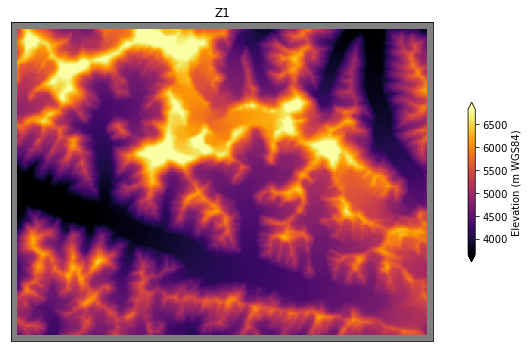

In [7]:
titles = ['Z1']
z1_full2plot = gf.z1
z1_full2plot.mask = dems_mask
clim = malib.calcperc(z1_full2plot, (2,98))
plot_array(z1_full2plot, clim, titles, 'inferno', 'Elevation (m WGS84)', fn=outdir_fig + glac_str + '_dem.png')

(422, 559)


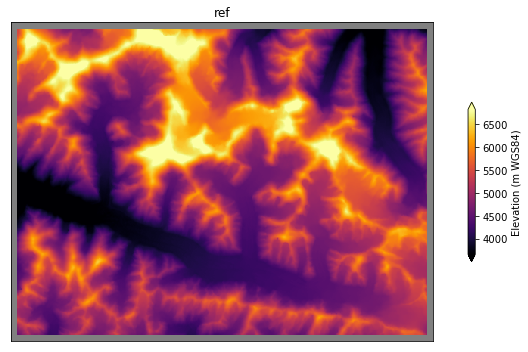

In [8]:
gf.ref = gf.z1
titles = ['ref']
z1_full2plot = gf.ref
z1_full2plot.mask = dems_mask
clim = malib.calcperc(z1_full2plot, (2,98))
plot_array(z1_full2plot, clim, titles, 'inferno', 'Elevation (m WGS84)', fn=outdir_fig + glac_str + '_dem.png')

print(gf.ref.shape)

RGI60-14.04477


Text(0.5, 1, 'UTM (m)')

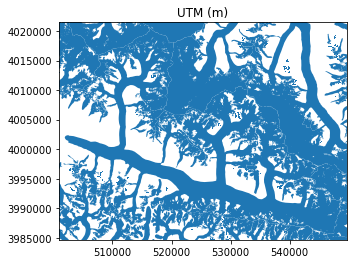

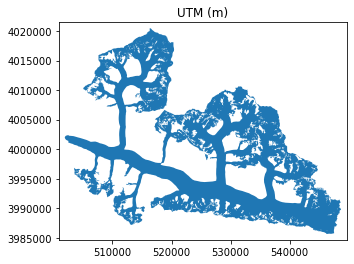

In [9]:
# Plot single glacier
rgiid = 'RGI60-' + gf.feat_fn.split('_')[0].split('.')[0].zfill(2) + '.' + gf.feat_fn.split('_')[0].split('.')[1]
glac_shp_proj = gpd.read_file(glac_shp_proj_fn)
glac_shp_single = glac_shp_proj[glac_shp_proj['RGIId'] == rgiid]
glac_shp_single = glac_shp_single.reset_index()

print(rgiid)

# Plot over region of interest
ax = glac_shp_proj.plot()
xlim = (warp_extent[0], warp_extent[2])
ylim = (warp_extent[1], warp_extent[3])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("UTM (m)")

ax = glac_shp_single.plot()
xlim = (warp_extent[0], warp_extent[2])
ylim = (warp_extent[1], warp_extent[3])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("UTM (m)")



HACK TO BYPASS VALID AREA


(422, 559)


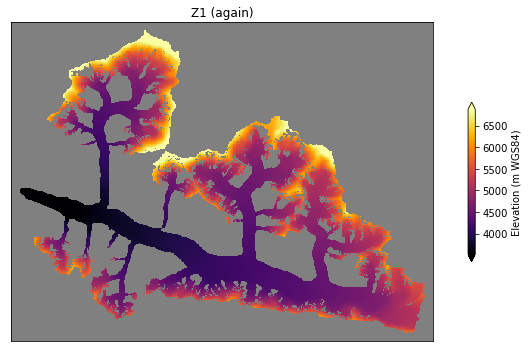

In [10]:
#Now apply glacier mask AND mask NaN values
glac_geom_mask = np.ma.mask_or(glac_geom_mask, dems_mask)
# nan_mask = np.ma.masked_invalid(gf.dz)
# glac_geom_mask = np.ma.mask_or(glac_geom_mask, nan_mask.mask)
gf.z1 = np.ma.array(gf.z1, mask=glac_geom_mask)
# gf.z2 = np.ma.array(gf.z2, mask=glac_geom_mask)
# gf.dz = np.ma.array(gf.dz, mask=glac_geom_mask)

gf.res = geolib.get_res(ds_dict['z1'])

print('\n\nHACK TO BYPASS VALID AREA\n\n')
gf.valid_area_perc = 100

# print('dz_count:', gf.dz.count())
# print(gf.dz.compressed()))

# #Compute area covered by valid pixels in m2
# gf.valid_area = gf.dz.count() * gf.res[0] * gf.res[1]
# #Compute percentage covered by total area of polygon
# gf.valid_area_perc = 100. * (gf.valid_area / gf.glac_area)
# if verbose:
#     print('valid area %:', gf.valid_area_perc)

# titles = ['Z1']
# z1_full2plot = gf.z1
# z1_full2plot.mask = dems_mask
# clim = malib.calcperc(z1_full2plot, (2,98))
# plot_array(z1_full2plot, clim, titles, 'inferno', 'Elevation (m WGS84)', fn='dem.png')

titles = ['Z1 (again)']
clim = malib.calcperc(gf.z1, (2,98))
plot_array(gf.z1, clim, titles, 'inferno', 'Elevation (m WGS84)', fn=outdir_fig + glac_str + '_dem.png')

print(gf.z1.shape)

In [11]:
if gf.valid_area_perc < (100. * min_valid_area_perc):
    if verbose:
        print("Not enough valid pixels. %0.1f%% percent of glacier polygon area" % (gf.valid_area_perc))
#     return None

else:
    #Filter dz - throw out abs differences >150 m

    #Compute dz, volume change, mass balance and stats
    gf.z1_stats = malib.get_stats(gf.z1)
    z1_elev_med = gf.z1_stats[5]
    z1_elev_min, z1_elev_max = malib.calcperc(gf.z1, (0.1, 99.9))
    
    #Caluclate stats for aspect and slope using z2
    #Requires GDAL 2.1+
    gf.z1_aspect = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='aspect', returnma=True), mask=glac_geom_mask)
    gf.z1_aspect_stats = malib.get_stats(gf.z1_aspect)
    z1_aspect_med = gf.z1_aspect_stats[5]
    gf.z1_slope = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='slope', returnma=True), mask=glac_geom_mask)
    gf.z1_slope_stats = malib.get_stats(gf.z1_slope)
    z1_slope_med = gf.z1_slope_stats[5]

#     #Load timestamp array, if available
#     if 'z1_date' in ds_dict:
#         gf.t1 = iolib.ds_getma(ds_dict['z1_date'])
#     else:
#         if isinstance(gf.t1, datetime):
#             gf.t1 = float(timelib.dt2decyear(gf.t1))
#         #else, assume we've hardcoded decimal year
#     gf.t1_mean = np.mean(gf.t1)

#     if 'z2_date' in ds_dict:
#         gf.t2 = iolib.ds_getma(ds_dict['z2_date'])
#     else:
#         if isinstance(gf.t2, datetime):
#             gf.t2 = float(timelib.dt2decyear(gf.t2))
#         #else, assume we've hardcoded decimal year
#     gf.t2_mean = np.mean(gf.t2)


    #Can estimate ELA values computed from hypsometry and typical AAR
    #For now, assume ELA is mean
    gf.z1_ela = None
    gf.z1_ela = gf.z1_stats[3]
#     gf.z2_ela = gf.z2_stats[3]
    #Note: in theory, the ELA should get higher with mass loss
    #In practice, using mean and same polygon, ELA gets lower as glacier surface thins
    if verbose:
        print("ELA(t1): %0.1f" % gf.z1_ela)
#         print("ELA(t2): %0.1f" % gf.z2_ela)

    """
    # This attempted to assign different densities above and below ELA
    if gf.z1_ela is None:
        gf.mb = gf.dhdt * rho_is
    else:
        #Initiate with average density
        gf.mb = gf.dhdt*(rho_is + rho_f)/2.
        #Everything that is above ELA at t2 is elevation change over firn, use firn density
        accum_mask = (gf.z2 > gf.z2_ela).filled(0).astype(bool)
    gf.mb[accum_mask] = (gf.dhdt*rho_f)[accum_mask]
    #Everything that is below ELA at t1 is elevation change over ice, use ice density
    abl_mask = (gf.z1 <= gf.z1_ela).filled(0).astype(bool)
    gf.mb[abl_mask] = (gf.dhdt*rho_is)[abl_mask]
    #Everything in between, use average of ice and firn density
    #mb[(z1 > z1_ela) || (z2 <= z2_ela)] = dhdt*(rhois + rho_f)/2.
    #Linear ramp
    #rho_f + z2*((rho_is - rho_f)/(z2_ela - z1_ela))
    #mb = np.where(dhdt < ela, dhdt*rho_i, dhdt*rho_s)
    """

    #Old approach
    #This is mb uncertainty map
    #gf.mb_sigma = np.ma.abs(gf.mb) * np.sqrt((rho_sigma/rho_is)**2 + (gf.dhdt_sigma/gf.dhdt)**2)
    #gf.mb_sigma_stats = malib.get_stats(gf.mb_sigma)
    #This is average mb uncertainty
    #gf.mb_mean_sigma = gf.mb_sigma_stats[3]

    #Now calculate mb for entire polygon
    #gf.mb_mean_totalarea = gf.mb_mean * gf.glac_area
    #Already have area uncertainty as percentage, just use directly
    #gf.mb_mean_totalarea_sigma = np.ma.abs(gf.mb_mean_totalarea) * np.sqrt((gf.mb_mean_sigma/gf.mb_mean)**2 + area_sigma_perc**2)

    #z2_elev_med, z2_elev_min, z2_elev_max, z2_elev_p16, z2_elev_p84, \
    outlist = [gf.glacnum, gf.cx, gf.cy, \
            z1_elev_med, z1_elev_min, z1_elev_max, \
            z1_slope_med, z1_aspect_med, \
#             gf.dhdt_mean, gf.dhdt_sigma, \
#             gf.mb_mean, gf.mb_mean_sigma, \
            gf.glac_area, 
#                gf.mb_total, gf.mb_total_sigma, \
#             gf.t1_mean, gf.t2_mean, gf.dt_mean, 
               gf.valid_area_perc]
    print(outlist)

    if extra_layers and (gf.glac_area_km2 > min_glac_area_writeout):
        if 'ice_thick' in ds_dict:
            #Load ice thickness
            gf.H = np.ma.array(iolib.ds_getma(ds_dict['ice_thick']), mask=glac_geom_mask)
            gf.H_mean = gf.H.mean()
        #These should be NaN or None
        outlist.append(gf.H_mean)
        print(outlist)

#         if 'debris_thick' in ds_dict:
#             gf.debris_thick = np.ma.array(iolib.ds_getma(ds_dict['debris_thick']), mask=glac_geom_mask)
#             gf.debris_thick_mean = gf.debris_thick.mean()
#         outlist.append(gf.debris_thick_mean)

#         if 'debris_class' in ds_dict:
#             #Load up debris cover maps
#             #Classes are: 1 = clean ice, 2 = debris, 3 = pond
#             gf.debris_class = np.ma.array(iolib.ds_getma(ds_dict['debris_class']), mask=glac_geom_mask)

#             #Compute debris/pond/clean percentages for entire polygon
#             if gf.debris_class.count() > 0:
#                 gf.perc_clean = 100. * (gf.debris_class == 1).sum()/gf.debris_class.count()
#                 gf.perc_debris = 100. * (gf.debris_class == 2).sum()/gf.debris_class.count()
#                 gf.perc_pond = 100. * (gf.debris_class == 3).sum()/gf.debris_class.count()
#             outlist.extend([gf.perc_debris, gf.perc_pond, gf.perc_clean])

        if 'vx' in ds_dict and 'vy' in ds_dict:
            #Load surface velocity maps
            gf.vx = np.ma.array(iolib.ds_getma(ds_dict['vx']), mask=glac_geom_mask)
            gf.vy = np.ma.array(iolib.ds_getma(ds_dict['vy']), mask=glac_geom_mask)
            gf.vm = np.ma.sqrt(gf.vx**2 + gf.vy**2)
            gf.vm_mean = gf.vm.mean()
            
            print(gf.vm_mean)

            if gf.H is not None:
                #Compute flux
                gf.Q = gf.H * v_col_f * np.array([gf.vx, gf.vy])
                #Note: np.gradient returns derivatives relative to axis number, so (y, x) in this case
                #Want x-derivative of x component
                gf.divQ = np.gradient(gf.Q[0])[1] + np.gradient(gf.Q[1])[0]

#                 gf.divQ = gf.H*(np.gradient(v_col_f*gf.vx)[1] + np.gradient(v_col_f*gf.vy)[0]) \
#                         + v_col_f*gf.vx*(np.gradient(gf.H)[1]) + v_col_f*gf.vy*(np.gradient(gf.H)[0])

                #Should smooth divQ, better handling of data gaps
                
        if 'ts' in ds_dict:
            #Load surface temperature maps
            gf.ts = np.ma.array(iolib.ds_getma(ds_dict['ts']), mask=glac_geom_mask)
    
        outlist.append(gf.vm_mean)
        print(outlist)

    if verbose:
        print('Area [km2]:', gf.glac_area / 1e6)
#         print('Mean mb: %0.2f +/- %0.2f mwe/yr' % (gf.mb_mean, gf.mb_mean_sigma))
#         print('Sum/Area mb: %0.2f mwe/yr' % (gf.mb_total/gf.glac_area))
#         print('Mean mb * Area: %0.2f +/- %0.2f m3we/yr' % (gf.mb_total, gf.mb_total_sigma))
# #         print('Sum mb: %0.2f m3we/yr' % gf.mb_total)
        print('-------------------------------')
    
    #Set up output header
    
    out_header = '%s,x,y,z_med,z_min,z_max,area_m2,valid_area_perc,slope_med,aspect_med' % glacnum_fieldname
    if extra_layers:
        out_header += ',H_m'
        out_header += ',vm_ma'

    nf = len(out_header.split(','))
    out_fmt = [glacnum_fmt,] + ['%0.3f'] * (nf - 1)
    
    #Write out mb stats for entire polygon - in case processing is interupted
    #out = np.array(outlist, dtype=float)
    out = np.full(len(out_fmt), np.nan)
    out[0:len(outlist)] = np.array(outlist, dtype=float)
    #Note, need a 2D array here, add 0 axis

    print(out)

    np.savetxt(out_csv_fn, out[np.newaxis,:], fmt=out_fmt, delimiter=',', header=out_header, comments='')
        

ELA(t1): 4947.8
['14.04477', 525661.7775043407, 4000033.239213784, 4852.72265625, 3208.617678222656, 7608.92449707032, 15.378817558288574, 208.3353271484375, 495257958.126013, 100]
['14.04477', 525661.7775043407, 4000033.239213784, 4852.72265625, 3208.617678222656, 7608.92449707032, 15.378817558288574, 208.3353271484375, 495257958.126013, 100, 120.05479452054794]
23.055563251296732
['14.04477', 525661.7775043407, 4000033.239213784, 4852.72265625, 3208.617678222656, 7608.92449707032, 15.378817558288574, 208.3353271484375, 495257958.126013, 100, 120.05479452054794, 23.055563251296732]
Area [km2]: 495.25795812601297
-------------------------------
[1.40447700e+01 5.25661778e+05 4.00003324e+06 4.85272266e+03
 3.20861768e+03 7.60892450e+03 1.53788176e+01 2.08335327e+02
 4.95257958e+08 1.00000000e+02 1.20054795e+02 2.30555633e+01]


In [12]:
#Do AED for all
#Compute mb using scaled AED vs. polygon
#Check for valid pixel count vs. feature area, fill if appropriate

if mb_plot and (gf.glac_area_km2 > min_glac_area_writeout):
    print('plot?')
#     dz_clim = (-2.0, 2.0)
#     if site == 'hma':
#         dz_clim = (-3.0, 3.0)
    z_bin_edges = hist_plot(gf, outdir, bin_width=bin_width)
#     gf.z1_hs = geolib.gdaldem_mem_ds(ds_dict['z1'], processing='hillshade', returnma=True)
#     gf.z2_hs = geolib.gdaldem_mem_ds(ds_dict['z2'], processing='hillshade', returnma=True)
#     map_plot(gf, z_bin_edges, outdir, dz_clim=dz_clim)

plot?
2


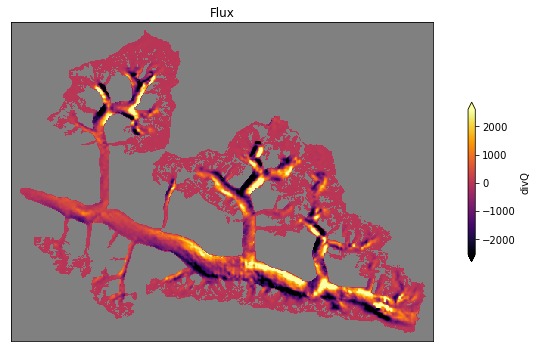

In [13]:
titles = ['Flux']
divQ_full2plot = gf.divQ
divQ_full2plot.mask = glac_geom_mask
clim = malib.calcperc(divQ_full2plot, (2,98))
plot_array(divQ_full2plot, clim, titles, 'inferno', 'divQ', fn=outdir_fig + glac_str +'_divQ.png')

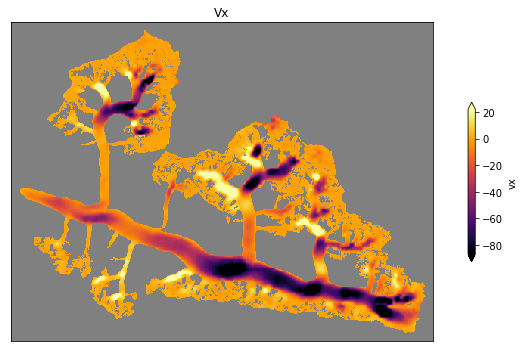

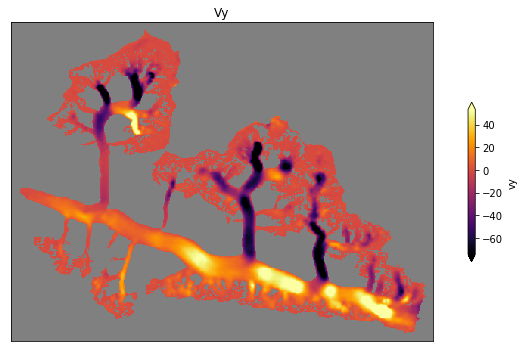

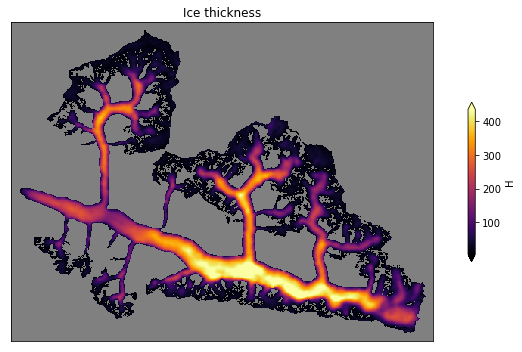

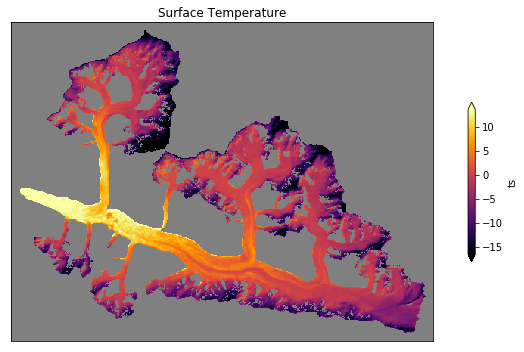

In [14]:
titles = ['Vx']
var_full2plot = gf.vx
var_full2plot.mask = glac_geom_mask
clim = malib.calcperc(var_full2plot, (2,98))
plot_array(var_full2plot, clim, titles, 'inferno', 'vx', fn=outdir_fig + glac_str +'_vx.png')

titles = ['Vy']
var_full2plot = gf.vy
var_full2plot.mask = glac_geom_mask
clim = malib.calcperc(var_full2plot, (2,98))
plot_array(var_full2plot, clim, titles, 'inferno', 'vy', fn=outdir_fig + glac_str +'_vy.png')

titles = ['Ice thickness']
var_full2plot = gf.H
var_full2plot.mask = glac_geom_mask
clim = malib.calcperc(var_full2plot, (2,98))
plot_array(var_full2plot, clim, titles, 'inferno', 'H', fn=outdir_fig + glac_str +'_ice_thickness.png')

titles = ['Surface Temperature']
var_full2plot = gf.ts
var_full2plot.mask = glac_geom_mask
clim = malib.calcperc(var_full2plot, (2,98))
plot_array(var_full2plot, clim, titles, 'inferno', 'ts', fn=outdir_fig + glac_str +'_ice_thickness.png')

mean ice thickness: 120.0 m


/Users/davidrounce/anaconda3/envs/debris_thickness_kennicott/lib/python3.6/site-packages/ipykernel_launcher.py:81: UserWarning: Warning: converting a masked element to nan.
/Users/davidrounce/anaconda3/envs/debris_thickness_kennicott/lib/python3.6/site-packages/ipykernel_launcher.py:84: UserWarning: Warning: converting a masked element to nan.
/Users/davidrounce/anaconda3/envs/debris_thickness_kennicott/lib/python3.6/site-packages/ipykernel_launcher.py:87: UserWarning: Warning: converting a masked element to nan.
/Users/davidrounce/anaconda3/envs/debris_thickness_kennicott/lib/python3.6/site-packages/ipykernel_launcher.py:90: UserWarning: Warning: converting a masked element to nan.


Mass is conserved? False
-30759874.87689209


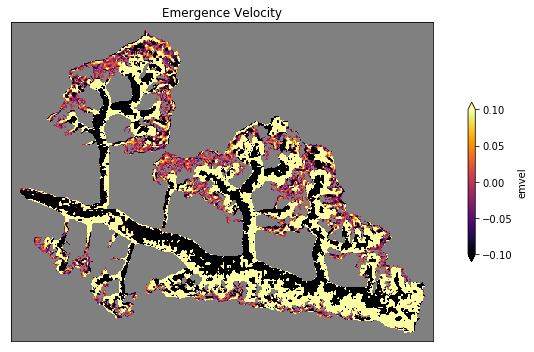

In [15]:
def emergence_pixels(vel_x_raw, vel_y_raw, icethickness_raw, xres, yres, 
                     vel_min=0, max_velocity=600, vel_depth_avg_factor=0.8, option_border=1,
                     positive_is_east=True, positive_is_north=True, constant_icethickness=False):
    """ Compute the emergence velocity using an ice flux approach
    """
    # Modify vel_y by multiplying velocity by -1 such that matrix operations agree with flow direction
    #    Specifically, a negative y velocity means the pixel is flowing south.
    #    However, if you were to subtract that value from the rows, it would head north in the matrix.
    #    This is due to the fact that the number of rows start at 0 at the top.
    #    Therefore, multipylying by -1 aligns the matrix operations with the flow direction
    if positive_is_north:
        vel_y = -1*vel_y_raw * vel_depth_avg_factor
    else:
        vel_y = vel_y_raw * vel_depth_avg_factor
    if positive_is_east:
        vel_x = vel_x_raw * vel_depth_avg_factor
    else:
        vel_x = -1*vel_x_raw * vel_depth_avg_factor
    vel_total = (vel_y**2 + vel_x**2)**0.5
    # Ice thickness
    icethickness = icethickness_raw.copy()
    if constant_icethickness:
        icethickness[:,:] = 1
    print('mean ice thickness:', np.round(icethickness.mean(),0), 'm')
    # Compute the initial volume
    volume_initial = icethickness * (xres * yres)
    pix_maxres = xres
    if yres > pix_maxres:
        pix_maxres = yres
    # Quality control options:
    # Apply a border based on the max specified velocity to prevent errors associated with pixels going out of bounds
    if option_border == 1:
        border = int(max_velocity / pix_maxres) + 1
        for r in range(vel_x.shape[0]):
            for c in range(vel_x.shape[1]):
                if (r < border) | (r >= vel_x.shape[0] - border) | (c < border) | (c >= vel_x.shape[1] - border):
                    vel_x[r,c] = 0
                    vel_y[r,c] = 0
    # Minimum/maximum velocity bounds
    vel_x[vel_total < vel_min] = 0
    vel_y[vel_total < vel_min] = 0
    vel_x[vel_total > max_velocity] = 0
    vel_y[vel_total > max_velocity] = 0
#     # Remove clusters of high velocity on stagnant portions of glaciers due to feature tracking of ice cliffs and ponds
#     if option_stagnantbands == 1:
#         vel_x[bands <= stagnant_band] = 0
#         vel_y[bands <= stagnant_band] = 0        
    # Compute displacement in units of pixels
    vel_x_pix = vel_x / xres
    vel_y_pix = vel_y / yres
    # Compute the displacement and fraction of pixels moved for all columns (x-axis)
    # col_x1 is the number of columns to the closest pixel receiving ice [ex. 2.6 returns 2, -2.6 returns -2]
    #    int() automatically rounds towards zero
    col_x1 = vel_x_pix.astype(int)
    # col_x2 is the number of columns to the further pixel receiving ice [ex. 2.6 returns 3, -2.6 returns -3]
    #    np.sign() returns a value of 1 or -1, so it's adding 1 pixel away from zero
    col_x2 = (vel_x_pix + np.sign(vel_x_pix)).astype(int)
    # rem_x2 is the fraction of the pixel that remains in the further pixel (col_x2) [ex. 2.6 returns 0.6, -2.6 returns 0.6]
    #    np.sign() returns a value of 1 or -1, so multiplying by that ensures you have a positive value
    #    then when you take the remainder using "% 1", you obtain the desired fraction
    rem_x2 = np.multiply(np.sign(vel_x_pix), vel_x_pix) % 1
    # rem_x1 is the fraction of the pixel that remains in the closer pixel (col_x1) [ex. 2.6 returns 0.4, -2.6 returns 0.4]
    rem_x1 = 1 - rem_x2
    # Repeat the displacement and fraction computations for all rows (y-axis)
    row_y1 = vel_y_pix.astype(int)
    row_y2 = (vel_y_pix + np.sign(vel_y_pix)).astype(int)
    rem_y2 = np.multiply(np.sign(vel_y_pix), vel_y_pix) % 1
    rem_y1 = 1 - rem_y2
          
    # Fill masked values with 0
    col_x1[col_x1.mask] = 0
    col_x2[col_x2.mask] = 0
    row_y1[row_y1.mask] = 0
    row_y2[row_y2.mask] = 0
          
    # Compute the mass flux for each pixel
    volume_final = np.zeros(volume_initial.shape)
    for r in range(vel_x.shape[0]):
        for c in range(vel_x.shape[1]):
            volume_final[r+row_y1[r,c], c+col_x1[r,c]] = (
                volume_final[r+row_y1[r,c], c+col_x1[r,c]] + rem_y1[r,c]*rem_x1[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y2[r,c], c+col_x1[r,c]] = (
                volume_final[r+row_y2[r,c], c+col_x1[r,c]] + rem_y2[r,c]*rem_x1[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y1[r,c], c+col_x2[r,c]] = (
                volume_final[r+row_y1[r,c], c+col_x2[r,c]] + rem_y1[r,c]*rem_x2[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y2[r,c], c+col_x2[r,c]] = (
                volume_final[r+row_y2[r,c], c+col_x2[r,c]] + rem_y2[r,c]*rem_x2[r,c]*volume_initial[r,c]
                )
    # Check that mass is conserved (threshold = 0.1 m x pixel_size**2)
    print('Mass is conserved?', (volume_final.sum() - volume_initial.sum()) < 0.1 * (xres * yres))
    print(np.nansum(volume_final) - np.nansum(volume_initial))
    # Final ice thickness
    icethickness_final = volume_final / (xres * yres)
    # Emergence velocity
    emergence_velocity = icethickness_final - icethickness
    return emergence_velocity

# Emergence computation
gf.emvel = emergence_pixels(gf.vx, gf.vy, gf.H, gf.res[0], gf.res[1], positive_is_east=False, 
                            positive_is_north=False, constant_icethickness=False, max_velocity=600, vel_min=0)

titles = ['Emergence Velocity']
var_full2plot = gf.emvel
var_full2plot.mask = dems_mask
clim = malib.calcperc(var_full2plot, (2,98))
plot_array(var_full2plot, clim, titles, 'inferno', 'emvel', fn= outdir_fig + glac_str +'_emergence_velocity.png')

In [16]:
#RGI uses 50 m bins
def hist_plot_wemvel(gf, outdir, bin_width=50.0, dz_clim=(-2.0, 2.0)):
    #print("Generating histograms")
    #Create bins for full range of input data and specified bin width

    #NOTE: these counts/areas are for valid pixels only
    #Not necessarily a true representation of actual glacier hypsometry
    #Need a void-filled DEM for this

    z_bin_edges, z_bin_centers = malib.get_bins(gf.z1, bin_width)
    #Need to compress here, otherwise histogram uses masked values!
    z1_bin_counts, z1_bin_edges = np.histogram(gf.z1.compressed(), bins=z_bin_edges)
    z1_bin_areas = z1_bin_counts * gf.res[0] * gf.res[1] / 1E6
    #RGI standard is integer thousandths of glaciers total area
    #Should check to make sure sum of bin areas equals total area
    #z1_bin_areas_perc = 100. * z1_bin_areas / np.sum(z1_bin_areas)
    z1_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)

    #If we only have one elevation grid with dhdt
    if gf.z2 is not None:
        z2_bin_counts, z2_bin_edges = np.histogram(gf.z2.compressed(), bins=z_bin_edges)
        z2_bin_areas = z2_bin_counts * gf.res[0] * gf.res[1] / 1E6
        #z2_bin_areas_perc = 100. * z2_bin_areas / np.sum(z2_bin_areas)
        z2_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)
    else:
        z2_bin_counts = z1_bin_counts
        z2_bin_edges = z1_bin_edges
        z2_bin_areas = z1_bin_areas
        z2_bin_areas_perc = z1_bin_areas_perc

    #Create arrays to store output
    slope_bin_med = np.ma.masked_all_like(z1_bin_areas)
    slope_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_med = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.dhdt is not None:
        mb_bin_med = np.ma.masked_all_like(z1_bin_areas)
        np.ma.set_fill_value(mb_bin_med, np.nan)
        mb_bin_mad = np.ma.masked_all_like(mb_bin_med)
        mb_bin_mean = np.ma.masked_all_like(mb_bin_med)
        mb_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_med = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mad = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mean = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_count = np.ma.masked_all_like(mb_bin_med)
    if gf.vm is not None:
        vm_bin_med = np.ma.masked_all_like(z1_bin_areas)
        vm_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.H is not None:
        H_bin_mean = np.ma.masked_all_like(z1_bin_areas)
        H_bin_std = np.ma.masked_all_like(z1_bin_areas)
        emvel_bin_mean = np.ma.masked_all_like(z1_bin_areas)
        emvel_bin_std = np.ma.masked_all_like(z1_bin_areas)
    if gf.debris_class is not None:
#         perc_clean = np.ma.masked_all_like(z1_bin_areas)
#         perc_debris = np.ma.masked_all_like(z1_bin_areas)
#         perc_pond = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_med = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_mad = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_clean_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_debris_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_pond_bin_med = np.ma.masked_all_like(mz1_bin_areas)

#         gf.dhdt_clean = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 1).data))
#         gf.dhdt_debris = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 2).data))
#         gf.dhdt_pond = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 3).data))

    #Bin sample count must be greater than this value
    min_bin_samp_count = 9

    #Loop through each bin and extract stats
    idx = np.digitize(gf.z1, z_bin_edges)
    for bin_n in range(z_bin_centers.size):
        if gf.dhdt is not None:
            mb_bin_samp = gf.mb_map[(idx == bin_n+1)]
            if mb_bin_samp.count() > min_bin_samp_count:
                mb_bin_med[bin_n] = malib.fast_median(mb_bin_samp)
                mb_bin_mad[bin_n] = malib.mad(mb_bin_samp)
                mb_bin_mean[bin_n] = mb_bin_samp.mean()
                mb_bin_std[bin_n] = mb_bin_samp.std()
            dhdt_bin_samp = gf.dhdt[(idx == bin_n+1)]
            if dhdt_bin_samp.count() > min_bin_samp_count:
                dhdt_bin_med[bin_n] = malib.fast_median(dhdt_bin_samp)
                dhdt_bin_mad[bin_n] = malib.mad(dhdt_bin_samp)
                dhdt_bin_mean[bin_n] = dhdt_bin_samp.mean()
                dhdt_bin_std[bin_n] = dhdt_bin_samp.std()
                dhdt_bin_count[bin_n] = dhdt_bin_samp.count()
        if gf.debris_thick is not None:
            debris_thick_bin_samp = gf.debris_thick[(idx == bin_n+1)]
            if debris_thick_bin_samp.size > min_bin_samp_count:
                debris_thick_med[bin_n] = malib.fast_median(debris_thick_bin_samp)
                debris_thick_mad[bin_n] = malib.mad(debris_thick_bin_samp)
        if gf.debris_class is not None:
            debris_class_bin_samp = gf.debris_class[(idx == bin_n+1)]
            dhdt_clean_bin_samp = gf.dhdt_clean[(idx == bin_n+1)]
            dhdt_debris_bin_samp = gf.dhdt_debris[(idx == bin_n+1)]
            dhdt_pond_bin_samp = gf.dhdt_pond[(idx == bin_n+1)]
            if debris_class_bin_samp.count() > min_bin_samp_count:
                perc_clean[bin_n] = 100. * (debris_class_bin_samp == 1).sum()/debris_class_bin_samp.count()
                perc_debris[bin_n] = 100. * (debris_class_bin_samp == 2).sum()/debris_class_bin_samp.count()
                perc_pond[bin_n] = 100. * (debris_class_bin_samp == 3).sum()/debris_class_bin_samp.count()
            if dhdt_clean_bin_samp.count() > min_bin_samp_count:
                dhdt_clean_bin_med[bin_n] = malib.fast_median(dhdt_clean_bin_samp)
            if dhdt_debris_bin_samp.count() > min_bin_samp_count:
                dhdt_debris_bin_med[bin_n] = malib.fast_median(dhdt_debris_bin_samp)
            if dhdt_pond_bin_samp.count() > min_bin_samp_count:
                dhdt_pond_bin_med[bin_n] = malib.fast_median(dhdt_pond_bin_samp)
        if gf.vm is not None:
            vm_bin_samp = gf.vm[(idx == bin_n+1)]
            if vm_bin_samp.size > min_bin_samp_count:
                vm_bin_med[bin_n] = malib.fast_median(vm_bin_samp)
                vm_bin_mad[bin_n] = malib.mad(vm_bin_samp)
        if gf.H is not None:
            H_bin_samp = gf.H[(idx == bin_n+1)]
            if H_bin_samp.size > min_bin_samp_count:
                H_bin_mean[bin_n] = H_bin_samp.mean()
                H_bin_std[bin_n] = H_bin_samp.std()
            emvel_bin_samp = gf.emvel[(idx == bin_n+1)]
            if emvel_bin_samp.size > min_bin_samp_count:
                emvel_bin_mean[bin_n] = emvel_bin_samp.mean()
                emvel_bin_std[bin_n] = emvel_bin_samp.std()
        slope_bin_samp = gf.z1_slope[(idx == bin_n+1)]
        if slope_bin_samp.size > min_bin_samp_count:
            slope_bin_med[bin_n] = malib.fast_median(slope_bin_samp)
            slope_bin_mad[bin_n] = malib.mad(slope_bin_samp)
        aspect_bin_samp = gf.z1_aspect[(idx == bin_n+1)]
        if aspect_bin_samp.size > min_bin_samp_count:
            aspect_bin_med[bin_n] = malib.fast_median(aspect_bin_samp)
            aspect_bin_mad[bin_n] = malib.mad(aspect_bin_samp)

    if gf.dhdt is not None:
        dhdt_bin_areas = dhdt_bin_count * gf.res[0] * gf.res[1] / 1E6
        #dhdt_bin_areas_perc = 100. * dhdt_bin_areas / np.sum(dhdt_bin_areas)
        dhdt_bin_areas_perc = 100. * (dhdt_bin_areas / gf.glac_area_km2)

    outbins_header = 'bin_center_elev_m,z1_bin_count_valid,z1_bin_area_valid_km2,z1_bin_area_perc,z2_bin_count_valid,z2_bin_area_valid_km2,z2_bin_area_perc,slope_bin_med,aspect_bin_med'
    fmt = '%0.1f,%0.0f,%0.3f,%0.2f,%0.0f,%0.3f,%0.2f,%0.2f,%0.2f'
    outbins = [z_bin_centers, z1_bin_counts, z1_bin_areas, z1_bin_areas_perc, z2_bin_counts, z2_bin_areas, z2_bin_areas_perc, slope_bin_med, aspect_bin_med]
    if gf.dhdt is not None:
        outbins_header += ',dhdt_bin_count,dhdt_bin_area_valid_km2,dhdt_bin_area_perc,dhdt_bin_med_ma,dhdt_bin_mad_ma,dhdt_bin_mean_ma,dhdt_bin_std_ma,mb_bin_med_mwea,mb_bin_mad_mwea,mb_bin_mean_mwea,mb_bin_std_mwea'
        fmt += ', %0.0f,%0.3f,%0.2f,%0.2f,%0.2f,%0.2f,%0.2f,%0.2f,%0.2f,%0.2f,%0.2f'
        outbins.extend([dhdt_bin_count, dhdt_bin_areas, dhdt_bin_areas_perc, dhdt_bin_med, dhdt_bin_mad, dhdt_bin_mean, dhdt_bin_std, \
                        mb_bin_med, mb_bin_mad, mb_bin_mean, mb_bin_std])
    if gf.debris_thick is not None:
        outbins_header += ',debris_thick_med_m,debris_thick_mad_m'
        fmt += ',%0.2f,%0.2f'
        debris_thick_med[debris_thick_med == -(np.inf)] = 0.00
        debris_thick_mad[debris_thick_mad == -(np.inf)] = 0.00
        outbins.extend([debris_thick_med, debris_thick_mad])
    if gf.debris_class is not None:
        outbins_header += ',perc_debris,perc_pond,perc_clean,dhdt_debris_med,dhdt_pond_med,dhdt_clean_med'
        fmt += ',%0.2f,%0.2f,%0.2f,%0.2f,%0.2f,%0.2f'
        outbins.extend([perc_debris, perc_pond, perc_clean, dhdt_debris_bin_med, dhdt_pond_bin_med, dhdt_clean_bin_med])
    if gf.vm is not None:
        outbins_header += ',vm_med,vm_mad'
        fmt += ',%0.2f,%0.2f'
        outbins.extend([vm_bin_med, vm_bin_mad])
    if gf.H is not None:
#         outbins_header += ', H_mean, H_std'
#         fmt += ', %0.2f, %0.2f'
#         outbins.extend([H_bin_mean, H_bin_std])
        outbins_header += ',H_mean,H_std,emvel_mean,emvel_std'
        fmt += ',%0.2f,%0.2f,%0.2f,%0.2f'
        outbins.extend([H_bin_mean, H_bin_std, emvel_bin_mean, emvel_bin_std])

    outbins = np.ma.array(outbins).T.astype('float32')
    np.ma.set_fill_value(outbins, np.nan)
    outbins = outbins.filled(np.nan)
    outbins_fn = os.path.join(outdir, gf.feat_fn+'_mb_bins_wemvel.csv')
    np.savetxt(outbins_fn, outbins, fmt=fmt, delimiter=',', header=outbins_header)

    #Create plots of elevation bins
    #print("Generating aed plot")
    #f,axa = plt.subplots(1,2, figsize=(6, 6))
    nsubplots = 0
    if gf.dhdt is not None:
        nsubplots += 1
    if gf.debris_thick is not None:
        nsubplots += 1
    if gf.vm is not None:
        nsubplots += 1
    if gf.H is not None:
        nsubplots += 1
    print(nsubplots)
    f,axa = plt.subplots(1,nsubplots, squeeze=False, figsize=(10, 7.5))
    f.suptitle(gf.feat_fn)
    fs = 9
    nplot = -1
    if gf.dhdt is not None:
        nplot += 1
        axa[0,nplot].plot(z1_bin_areas, z_bin_centers, label='%0.2f' % gf.t1_mean)
        axa[0,nplot].axhline(gf.z1_ela, ls=':', c='C0')
        if gf.z2 is not None:
            axa[0,nplot].plot(z2_bin_areas, z_bin_centers, label='%0.2f' % gf.t2_mean)
            axa[0,nplot].axhline(gf.z2_ela, ls=':', c='C1')
        axa[0,nplot].legend(prop={'size':8}, loc='upper right')
        axa[0,nplot].set_ylabel('Elevation (m WGS84)', fontsize=fs)
        axa[0,nplot].set_xlabel('Area $\mathregular{km^2}$', fontsize=fs)
        axa[0,nplot].yaxis.set_ticks_position('both')
        # pltlib.minorticks_on(axa[0])

        nplot += 1
        axa[0,nplot].axvline(0, lw=1.0, c='k')
        """
        #Plot flux divergence values for each bin
        if gf.vm is not None and gf.H is not None:
            divQ_bin_mean = np.gradient(H_bin_mean * vm_bin_med * v_col_f)
            axa[1].plot(divQ_bin_mean, z_bin_centers, color='green')
        """
        axa[0,nplot].plot(mb_bin_med, z_bin_centers, color='k')
        axa[0,nplot].axvline(gf.mb_mean, lw=0.5, ls=':', c='k', label='%0.2f m w.e./yr' % gf.mb_mean)
        axa[0,nplot].fill_betweenx(z_bin_centers, mb_bin_med-mb_bin_mad, mb_bin_med+mb_bin_mad, color='k', alpha=0.1)
        axa[0,nplot].fill_betweenx(z_bin_centers, 0, mb_bin_med, where=(mb_bin_med<0), color='r', alpha=0.2)
        axa[0,nplot].fill_betweenx(z_bin_centers, 0, mb_bin_med, where=(mb_bin_med>0), color='b', alpha=0.2)
        #axa[nplot].set_xlabel('dh/dt (m/yr)')
        axa[0,nplot].set_xlabel('Mass balance (m w.e./yr)', fontsize=fs)
        axa[0,nplot].legend(prop={'size':8}, loc='upper right')
        axa[0,nplot].yaxis.set_ticks_position('both')
        # pltlib.minorticks_on(axa[1])
        #Hide y-axis labels
        axa[0,nplot].axes.yaxis.set_ticklabels([])
        axa[0,nplot].set_xlim(*dz_clim)

    if gf.debris_thick is not None:
        nplot += 1
        axa[0,nplot].errorbar(debris_thick_med*100., z_bin_centers, xerr=debris_thick_mad*100, color='k', fmt='o', ms=3, label='Debris Thickness', alpha=0.6)
    if gf.debris_class is not None:
        axa[0,nplot].plot(perc_debris, z_bin_centers, color='sienna', label='Debris Coverage')
        axa[0,nplot].plot(perc_pond, z_bin_centers, color='turquoise', label='Pond Coverage')
    if gf.debris_thick is not None or gf.debris_class is not None:
        axa[0,nplot].set_xlim(0, 100)
        axa[0,nplot].yaxis.set_ticks_position('both')
        # pltlib.minorticks_on(axa[2])
        axa[0,nplot].axes.yaxis.set_ticklabels([])
        axa[0,nplot].legend(prop={'size':8}, loc='upper right')
        axa[0,nplot].set_xlabel('Debris thickness (cm), coverage (%)', fontsize=fs)

    if gf.H is not None:
        nplot += 1
        axa[0,nplot].plot(H_bin_mean, z_bin_centers, color='b', label='H (%0.2f m)' % gf.H_mean)
        axa[0,nplot].fill_betweenx(z_bin_centers, H_bin_mean-H_bin_std, H_bin_mean+H_bin_std, color='b', alpha=0.1)
        axa[0,nplot].set_xlabel('Ice Thickness (m)', fontsize=fs)
        axa[0,nplot].legend(prop={'size':8}, loc='lower right')
        # pltlib.minorticks_on(axa[3])
        #axa[nplot].set_xlim(0, 400)
        axa[0,nplot].yaxis.tick_left()
        axa[0,nplot].yaxis.set_ticks_position('both')
        axa[0,nplot].yaxis.set_label_position("right")
    
    if gf.vm is not None:
        nplot += 1
#         ax4 = axa[0,nplot].twinx()
        axa[0,nplot].set_xlabel('Velocity (m/yr)', fontsize=fs)
        axa[0,nplot].plot(vm_bin_med, z_bin_centers, color='g', label='Vm (%0.2f m/yr)' % gf.vm_mean)
        axa[0,nplot].fill_betweenx(z_bin_centers, vm_bin_med-vm_bin_mad, vm_bin_med+vm_bin_mad, color='g', alpha=0.1)
        #ax4.set_xlim(0, 50)
        axa[0,nplot].xaxis.tick_bottom()
        axa[0,nplot].xaxis.set_label_position("bottom")
        axa[0,nplot].legend(prop={'size':8}, loc='upper right')
        
        nplot += 1
#         axa[0,nplot].set_xlabel('divQ (??)', fontsize=fs)
#         axa[0,nplot].plot(vm_bin_med, z_bin_centers, color='g', label='Vm (%0.2f m/yr)' % gf.vm_mean)
#         axa[0,nplot].fill_betweenx(z_bin_centers, vm_bin_med-vm_bin_mad, vm_bin_med+vm_bin_mad, color='g', alpha=0.1)
#         #ax4.set_xlim(0, 50)
#         axa[0,nplot].xaxis.tick_bottom()
#         axa[0,nplot].xaxis.set_label_position("bottom")
#         axa[0,nplot].legend(prop={'size':8}, loc='upper right')
#         gf.divQ
    
#     if gf.vm is not None:
#         nplot += 1
# #         ax4 = axa[0,nplot].twinx()
#         axa[0,nplot].set_xlabel('Velocity (m/yr)', fontsize=fs)
#         axa[0,nplot].plot(vm_bin_med, z_bin_centers, color='g', label='Vm (%0.2f m/yr)' % gf.vm_mean)
#         axa[0,nplot].fill_betweenx(z_bin_centers, vm_bin_med-vm_bin_mad, vm_bin_med+vm_bin_mad, color='g', alpha=0.1)
#         #ax4.set_xlim(0, 50)
#         axa[0,nplot].xaxis.tick_bottom()
#         axa[0,nplot].xaxis.set_label_position("bottom")
#         axa[0,nplot].legend(prop={'size':8}, loc='upper right')

    plt.tight_layout()
    #Make room for suptitle
    plt.subplots_adjust(top=0.95, wspace=0.1)
    #print("Saving aed plot")
    fig_fn = os.path.join(outdir_fig, gf.feat_fn+'_mb_aed.png')
    #plt.savefig(fig_fn, bbox_inches='tight', dpi=300)
    plt.savefig(fig_fn, dpi=300)
    plt.close(f)
    outbins_df = pd.DataFrame(outbins, columns=outbins_header.split(','))
    return z_bin_edges, outbins_df

z_bin_edges, outbins_df = hist_plot_wemvel(gf, outdir_csv, bin_width=bin_width)

2


In [17]:
print(bin_width,z_bin_edges[0:10])

5 [3130. 3135. 3140. 3145. 3150. 3155. 3160. 3165. 3170. 3175.]


In [18]:
outbins_df

,bin_center_elev_m,z1_bin_count_valid,z1_bin_area_valid_km2,z1_bin_area_perc,z2_bin_count_valid,z2_bin_area_valid_km2,z2_bin_area_perc,slope_bin_med,aspect_bin_med,vm_med,vm_mad,H_mean,H_std,emvel_mean,emvel_std
0,3132.5,4.0,0.030470,0.006152,4.0,0.030470,0.006152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3137.5,0.0,0.000000,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3142.5,2.0,0.015235,0.003076,2.0,0.015235,0.003076,14.703266,248.002075,1.098199,0.999685,17.859665,7.907256,NaN,NaN
3,3147.5,7.0,0.053323,0.010767,7.0,0.053323,0.010767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3152.5,1.0,0.007618,0.001538,1.0,0.007618,0.001538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,7712.5,1.0,0.007618,0.001538,1.0,0.007618,0.001538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
917,7717.5,1.0,0.007618,0.001538,1.0,0.007618,0.001538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
918,7722.5,1.0,0.007618,0.001538,1.0,0.007618,0.001538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
919,7727.5,1.0,0.007618,0.001538,1.0,0.007618,0.001538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(422, 559)


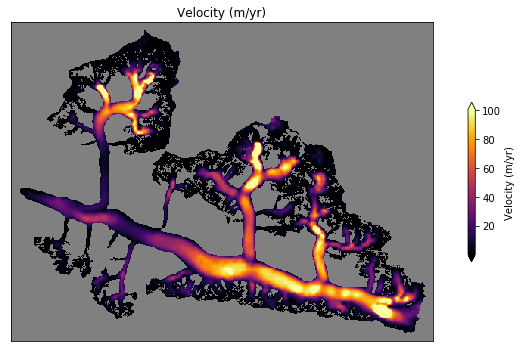

In [19]:
gf.vtot = (gf.vx**2 + gf.vy**2)**0.5

titles = ['Velocity (m/yr)']
var_full2plot = gf.vtot
var_full2plot.mask = glac_geom_mask
clim = malib.calcperc(var_full2plot, (2,98))
plot_array(var_full2plot, clim, titles, 'inferno', 'Velocity (m/yr)', fn=outdir_fig + glac_str +'_velocity.png')

print(var_full2plot.shape)

In [20]:
print('\n\n\n===== HERE IS WHERE WE USED TO SWITCH TO THE hma_melt2thickness.py: =====' + 
      '\n  1. need meltmodel output for subdebris melt inversion\n\n\n')




===== HERE IS WHERE WE USED TO SWITCH TO THE hma_melt2thickness.py: =====
  1. need meltmodel output for subdebris melt inversion





In [21]:
print('Processing melt2thickness.py in notebook instead of in file')
import hma_input as input

import os
#import rasterio
#import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# Local libraries
import hma_input as input

#%% ===== Input Data =====
# debris_thicknesses = list(np.arange(2,500,2))
debris_thicknesses = list(np.arange(0,500,10))
debris_thicknesses[0] = 2

output_sample_fn = 'Rounce2015_' + input.roi + '_debris_XXcm_20191206.csv'
output_data_fp = input.main_directory + '/hma_data/output/exp3_20191206/'
output_fp = input.main_directory + '/hma_data/output/'
if os.path.exists(output_fp) == False:
    os.makedirs(output_fp)
mb_fullfn = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/Shean_2019_0213/' + 
             'mb_combined_20190213_nmad_bins/' + gf.feat_fn + '_mb_bins.csv')

if ~os.path.exists(output_data_fp + output_sample_fn.replace('1',str(2))):
    print('\n\n\n!!!!! MUST RUN THE MELTMODEL.PY SCRIPT FIRST TO GET DATA FOR SUB-DEBRIS INVERSION !!!!!\n\n\n')

Processing melt2thickness.py in notebook instead of in file



!!!!! MUST RUN THE MELTMODEL.PY SCRIPT FIRST TO GET DATA FOR SUB-DEBRIS INVERSION !!!!!





In [22]:
#%% ===== Debris Thickness vs. Surface Lowering =====
debris_melt_df = pd.DataFrame(np.zeros((len(debris_thicknesses),2)), columns=['debris_thickness', 'melt_mwea'])
for ndebris, debris_thickness in enumerate(debris_thicknesses):
    output_fullfn = output_data_fp + output_sample_fn.replace('XX',str(debris_thickness))          
    # Hack because sometimes output debris thickness 1cm less due to the integer rounding
    if os.path.exists(output_fullfn) == False:
        output_fullfn = output_data_fp + output_sample_fn.replace('XX',str(debris_thickness-1))
    
    output_ds = pd.read_csv(output_fullfn)
    output_ds['Time'] = [np.datetime64(x) for x in output_ds['Time'].values]
    
    melt_mwea = (output_ds['Melt [mwe]'].sum() / 
                 ((output_ds['Time'].values[-1] - output_ds['Time'].values[0]).astype('timedelta64[D]').astype(int) 
                  / 365.25))
    debris_melt_df.loc[ndebris] = debris_thickness / 100, melt_mwea
    print(str(np.round(debris_thickness/100,2)) + ' m: ' + str(np.round(melt_mwea,2)) + ' mwea')

0.02 m: 2.99 mwea
0.1 m: 1.72 mwea
0.2 m: 0.8 mwea
0.3 m: 0.42 mwea
0.4 m: 0.27 mwea
0.5 m: 0.21 mwea
0.6 m: 0.17 mwea
0.7 m: 0.15 mwea
0.8 m: 0.13 mwea
0.9 m: 0.12 mwea
1.0 m: 0.11 mwea
1.1 m: 0.1 mwea
1.2 m: 0.09 mwea
1.3 m: 0.09 mwea
1.4 m: 0.08 mwea
1.5 m: 0.08 mwea
1.6 m: 0.07 mwea
1.7 m: 0.07 mwea
1.8 m: 0.07 mwea
1.9 m: 0.06 mwea
2.0 m: 0.06 mwea
2.1 m: 0.06 mwea
2.2 m: 0.05 mwea
2.3 m: 0.05 mwea
2.4 m: 0.05 mwea
2.5 m: 0.05 mwea
2.6 m: 0.04 mwea
2.7 m: 0.04 mwea
2.8 m: 0.04 mwea
2.9 m: 0.04 mwea
3.0 m: 0.03 mwea
3.1 m: 0.03 mwea
3.2 m: 0.03 mwea
3.3 m: 0.03 mwea
3.4 m: 0.03 mwea
3.5 m: 0.02 mwea
3.6 m: 0.02 mwea
3.7 m: 0.02 mwea
3.8 m: 0.02 mwea
3.9 m: 0.02 mwea
4.0 m: 0.02 mwea
4.1 m: 0.02 mwea
4.2 m: 0.01 mwea
4.3 m: 0.01 mwea
4.4 m: 0.01 mwea
4.5 m: 0.01 mwea
4.6 m: 0.01 mwea
4.7 m: 0.01 mwea
4.8 m: 0.01 mwea
4.9 m: 0.01 mwea


In [23]:
# fit_idx = np.where(debris_melt_df.debris_thickness <= 5)[0]
fit_idx = list(debris_melt_df.index.values)
fit_idx = fit_idx[2:]
print('Fit to a subset of data (not thinnest values) to capture this portion of the curve well' + 
      '\n  - any discrepancies at < 0.1 m are going to be very small because melt varies so drastically\n\n')

print(debris_melt_df.loc[fit_idx,'debris_thickness'].values)

Fit to a subset of data (not thinnest values) to capture this portion of the curve well
  - any discrepancies at < 0.1 m are going to be very small because melt varies so drastically


[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9
 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7
 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9]


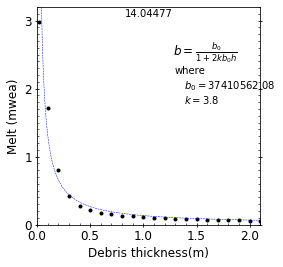

In [24]:
# PLOT CURVE
# fit curve
def melt_fromdebris_func(h, a, k):
    """ estimate melt from debris thickness (h is debris thickness, a and k are coefficients) """
    return a / (1 + 2 * k * a * h)
def debris_frommelt_func(b, a, k):
    """ estimate debris thickness from melt (b is melt, a and k are coefficients) """
    return (a - b) / (2*k*a*b)
func_coeff, pcov = curve_fit(melt_fromdebris_func, 
                             debris_melt_df.debris_thickness.values[fit_idx], 
                             debris_melt_df.melt_mwea.values[fit_idx])
fit_melt = melt_fromdebris_func(debris_melt_df.debris_thickness.values, func_coeff[0], func_coeff[1])
debris_4curve = np.arange(0.01,5.01,0.01)
melt_4curve = melt_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1])

# plot curve
fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
ax[0,0].plot(debris_melt_df['debris_thickness'], debris_melt_df['melt_mwea'], 'o', 
             color='k', markersize=3, zorder=1)
ax[0,0].plot(debris_4curve, melt_4curve, 
             color='b', linewidth=0.5, linestyle='--', zorder=2, label='plot1')
# text
ax[0,0].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
             transform=ax[0,0].transAxes)
eqn_text = r'$b = \frac{b_{0}}{1 + 2kb_{0}h}$'
coeff1_text = r'$b_{0} = ' + str(np.round(func_coeff[0],2)) + '$' 
coeff2_text = r'$k = ' + str(np.round(func_coeff[1],2)) + '$' 
# coeff$\frac{b_{0}}{1 + 2kb_{0}h}$'
ax[0,0].text(0.9, 0.85, eqn_text, size=12, horizontalalignment='right', verticalalignment='top', 
             transform=ax[0,0].transAxes)
ax[0,0].text(0.615, 0.73, 'where', size=10, horizontalalignment='left', verticalalignment='top', 
             transform=ax[0,0].transAxes)
ax[0,0].text(0.66, 0.67, coeff1_text, size=10, horizontalalignment='left', verticalalignment='top', 
             transform=ax[0,0].transAxes)
ax[0,0].text(0.66, 0.6, coeff2_text, size=10, horizontalalignment='left', verticalalignment='top', 
             transform=ax[0,0].transAxes)
# X-label
ax[0,0].set_xlabel('Debris thickness(m)', size=12)
ax[0,0].set_xlim(0, 2.1)
#ax[0,0].set_xlim(0, debris_melt_df.debris_thickness.max())
ax[0,0].xaxis.set_tick_params(labelsize=12)
ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
# Y-label
ax[0,0].set_ylabel('Melt (mwea)', size=12)
ax[0,0].set_ylim(0,(int(debris_melt_df.melt_mwea.values.max()/0.1)+3)*0.1)
ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(1))
ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(0.1))
# Tick parameters
ax[0,0].yaxis.set_ticks_position('both')
ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')               
# Save plot
fig.set_size_inches(4, 4)
figure_fn = 'debris_melt_curve.png'
fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300)  


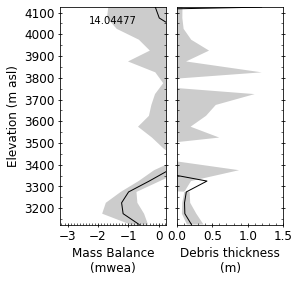

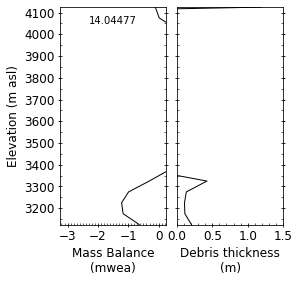

In [25]:
#%% ===== DERIVE DEBRIS THICKNESS FROM MASS BALANCE DATA =====
mb_df = pd.read_csv(mb_fullfn)
mb_df.loc[:,:] = mb_df.values.astype(np.float64)
mb_df['debris_thickness'] = debris_frommelt_func(-1*mb_df[' mb_bin_mean_mwea'].values, func_coeff[0], func_coeff[1])
mb_df['mb_bin_mean_mwea_1stdlow'] = mb_df[' mb_bin_mean_mwea'] - mb_df[' mb_bin_std_mwea']
mb_df['mb_bin_mean_mwea_1stdhigh'] = mb_df[' mb_bin_mean_mwea'] + mb_df[' mb_bin_std_mwea']
mb_df['debris_thickness_1stdlow'] = debris_frommelt_func(-1*mb_df['mb_bin_mean_mwea_1stdlow'].values, 
                                                          func_coeff[0], func_coeff[1])
mb_df['debris_thickness_1stdhigh'] = debris_frommelt_func(-1*mb_df['mb_bin_mean_mwea_1stdhigh'].values, 
                                                          func_coeff[0], func_coeff[1])

# PLOT MASS BALANCE AND DEBRIS THICKNESS VS. ELEVATION WITHOUT EMERGENCE VELOCITIES
# Mass balance
fig, ax = plt.subplots(1, 2, squeeze=False, sharex=False, sharey=True, gridspec_kw = {'wspace':0.1, 'hspace':0.15})
ax[0,0].plot(mb_df[' mb_bin_mean_mwea'], mb_df['# bin_center_elev_m'], color='k', linewidth=1, zorder=2)
ax[0,0].fill_betweenx(mb_df['# bin_center_elev_m'], 
                      mb_df['mb_bin_mean_mwea_1stdlow'], mb_df['mb_bin_mean_mwea_1stdhigh'], 
                      facecolor='k', alpha=0.2, zorder=1)
# text
fig.text(0.5, 0.96, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
             transform=ax[0,0].transAxes)
# X-label
ax[0,0].set_xlabel('Mass Balance\n(mwea)', size=12)
ax[0,0].set_xlim(-3.25, 0.25)
#ax[0,0].set_xlim(0, debris_melt_df.debris_thickness.max())
ax[0,0].xaxis.set_tick_params(labelsize=12)
ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(1))
ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
# Y-label
ylower = mb_df['# bin_center_elev_m'].min()
yupper = ylower + 1000
ax[0,0].set_ylabel('Elevation (m asl)', size=12)
ax[0,0].set_ylim(ylower,yupper)
ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(100))
ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(50))
# Tick parameters
ax[0,0].yaxis.set_ticks_position('both')
ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')       

# Debris thickness
ax[0,1].plot(mb_df['debris_thickness'], mb_df['# bin_center_elev_m'], color='k', linewidth=1, zorder=2)
#ax[0,0].plot(mb_df['MassBal_25'], mb_df['E'], color='k', linewidth=0.5, zorder=2)
#ax[0,0].plot(mb_df['MassBal_75'], mb_df['E'], color='k', linewidth=0.5, zorder=2)
ax[0,1].fill_betweenx(mb_df['# bin_center_elev_m'], 
                      mb_df['debris_thickness_1stdlow'], mb_df['debris_thickness_1stdhigh'], 
                      facecolor='k', alpha=0.2, zorder=1)
# X-label
ax[0,1].set_xlabel('Debris thickness\n(m)', size=12)
ax[0,1].set_xlim(0, 1.5) 
ax[0,1].xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax[0,1].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
# Y-label
ax[0,1].set_ylim(ylower,yupper)
# Tick parameters
ax[0,1].yaxis.set_ticks_position('both')
ax[0,1].tick_params(axis='both', which='major', labelsize=12, direction='inout')
ax[0,1].tick_params(axis='both', which='minor', labelsize=10, direction='in')       
        
# Save plot
fig.set_size_inches(4, 4)
figure_fn = 'elev_mb_debris.png'
fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300) 

#%% ===== EMERGENCE VELOCITIES ==========================================
# CURRENTLY PROCESSED IN IPYTHON NOTEBOOK USING SHEAN GMBTOOLS-TYPE FILE 'emergence_velocity.ipynb'
emergence_fullfn = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/Shean_2019_0213/' + 
                    'mb_combined_20190213_nmad_bins/csv/' + gf.feat_fn + '_mb_bins_wemvel.csv')
emergence_df = pd.read_csv(emergence_fullfn)
emergence_df['area_cumsum'] = np.cumsum(emergence_df['z1_bin_area_valid_km2'])

binsize_mb = mb_df.loc[1,'# bin_center_elev_m'] - mb_df.loc[0,'# bin_center_elev_m']
emvel_binsize = emergence_df['# bin_center_elev_m'].values[1] - emergence_df['# bin_center_elev_m'].values[0]
emergence_shift_idx = np.where(emergence_df.area_cumsum.values < mb_df.loc[0,' z1_bin_area_valid_km2'])[0][-1]
mb_offset = (mb_df.loc[0, '# bin_center_elev_m'] + binsize_mb/2 - emvel_binsize / 2 - 
             emergence_df.loc[emergence_shift_idx, '# bin_center_elev_m'])
                      
emergence_df['# bin_center_elev_m'] = emergence_df['# bin_center_elev_m'] + mb_offset
emergence_df['E_low'] = emergence_df['# bin_center_elev_m'] - emvel_binsize/2
emergence_df['E_high'] = emergence_df['# bin_center_elev_m'] + emvel_binsize/2

# Get mean emergence velocity to coincide with elevation bins
mb_df['E_low'] =  mb_df['# bin_center_elev_m'] - binsize_mb/2
mb_df['E_high'] = mb_df['# bin_center_elev_m'] + binsize_mb/2

mb_df['em_idx_low'] = np.nan
mb_df['em_idx_high'] = np.nan
for x in mb_df.index.values:
    rows_low = np.where(mb_df.E_low.values[x] == emergence_df.E_low.values)[0]
    if len(rows_low) > 0:
        mb_df.loc[x,'em_idx_low'] = rows_low[0]
    elif x == 0:
        mb_df.loc[x,'em_idx_low'] = 0
        
    rows_high = np.where(mb_df.E_high.values[x] == emergence_df.E_high.values)[0]
    if len(rows_high) > 0:
        mb_df.loc[x,'em_idx_high'] = rows_high[0]
    elif len(rows_high) == 0 and ~np.isnan(mb_df.loc[x,'em_idx_low']):
        mb_df.loc[x,'em_idx_high'] = emergence_df.index.values[-1]

emergence_df['emvel*area'] = emergence_df.emvel_mean * emergence_df.z1_bin_area_valid_km2
emergence_df['emvel*area_1stdlow'] = (emergence_df.emvel_mean - emergence_df.emvel_std) * emergence_df.z1_bin_area_valid_km2
emergence_df['emvel*area_1stdhigh'] = (emergence_df.emvel_mean + emergence_df.emvel_std) * emergence_df.z1_bin_area_valid_km2
            
mb_df['emvel_myr'] = np.nan
for x in mb_df.index.values:
    if ~np.isnan(mb_df.loc[x,'em_idx_low']):
        mb_df.loc[x,'emvel_myr'] = (
                emergence_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'emvel*area'].sum() / 
                emergence_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
#larsen_data['emvel_myr_1stdlow'] = (
#        [emvel_data.loc[larsen_data.loc[x,'em_idx_low']:larsen_data.loc[x,'em_idx_high'], 'emvel*area_1stdlow'].sum() / 
#         emvel_data.loc[larsen_data.loc[x,'em_idx_low']:larsen_data.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum()
#         for x in larsen_data.index.values])
#larsen_data['emvel_myr_1stdhigh'] = (
#        [emvel_data.loc[larsen_data.loc[x,'em_idx_low']:larsen_data.loc[x,'em_idx_high'], 'emvel*area_1stdhigh'].sum() / 
#         emvel_data.loc[larsen_data.loc[x,'em_idx_low']:larsen_data.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum()
#         for x in larsen_data.index.values])

mb_df['mb_wem'] = mb_df[' mb_bin_mean_mwea'] - mb_df['emvel_myr']
##larsen_data['mb_wem_25'] = larsen_data['MassBal_25'] - larsen_data['emvel_myr_1stdhigh']
##larsen_data['mb_wem_75'] = larsen_data['MassBal_75'] - larsen_data['emvel_myr_1stdlow']
#larsen_data['mb_wem_25'] = larsen_data['MassBal_25'] - larsen_data['emvel_myr']
#larsen_data['mb_wem_75'] = larsen_data['MassBal_75'] - larsen_data['emvel_myr']
#larsen_data['debris_thickness_wem'] = debris_frommelt_func(-1*larsen_data['mb_wem'].values, func_coeff[0], func_coeff[1])
#larsen_data['debris_thickness_wem_25'] = debris_frommelt_func(-1*larsen_data['mb_wem_25'].values, 
#                                                          func_coeff[0], func_coeff[1])
#larsen_data['debris_thickness_wem_75'] = debris_frommelt_func(-1*larsen_data['mb_wem_75'].values, 
#                                                          func_coeff[0], func_coeff[1])

mb_df['debris_thickness_wem'] = debris_frommelt_func(-1*mb_df['mb_wem'].values, func_coeff[0], func_coeff[1])

#%% ===== PLOT MASS BALANCE AND DEBRIS THICKNESS VS. ELEVATION WITH EMERGENCE VELOCITIES ======
# Mass balance
fig, ax = plt.subplots(1, 2, squeeze=False, sharex=False, sharey=True, gridspec_kw = {'wspace':0.1, 'hspace':0.15})
ax[0,0].plot(mb_df['mb_wem'], mb_df['# bin_center_elev_m'], color='k', linewidth=1, zorder=2)
#ax[0,0].fill_betweenx(mb_df['# bin_center_elev_m'], 
#                      mb_df['mb_bin_mean_mwea_1stdlow'], mb_df['mb_bin_mean_mwea_1stdhigh'], 
#                      facecolor='k', alpha=0.2, zorder=1)
# text
fig.text(0.5, 0.96, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
             transform=ax[0,0].transAxes)
# X-label
ax[0,0].set_xlabel('Mass Balance\n(mwea)', size=12)
ax[0,0].set_xlim(-3.25, 0.25)
#ax[0,0].set_xlim(0, debris_melt_df.debris_thickness.max())
ax[0,0].xaxis.set_tick_params(labelsize=12)
ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(1))
ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
# Y-label
ylower = mb_df['# bin_center_elev_m'].min()
yupper = ylower + 1000
ax[0,0].set_ylabel('Elevation (m asl)', size=12)
ax[0,0].set_ylim(ylower,yupper)
ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(100))
ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(50))
# Tick parameters
ax[0,0].yaxis.set_ticks_position('both')
ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')       

# Debris thickness
ax[0,1].plot(mb_df['debris_thickness_wem'], mb_df['# bin_center_elev_m'], color='k', linewidth=1, zorder=2)
#ax[0,0].plot(mb_df['MassBal_25'], mb_df['E'], color='k', linewidth=0.5, zorder=2)
#ax[0,0].plot(mb_df['MassBal_75'], mb_df['E'], color='k', linewidth=0.5, zorder=2)
#ax[0,1].fill_betweenx(mb_df['# bin_center_elev_m'], 
#                      mb_df['debris_thickness_1stdlow'], mb_df['debris_thickness_1stdhigh'], 
#                      facecolor='k', alpha=0.2, zorder=1)
# X-label
ax[0,1].set_xlabel('Debris thickness\n(m)', size=12)
ax[0,1].set_xlim(0, 1.5) 
ax[0,1].xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax[0,1].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
# Y-label
ax[0,1].set_ylim(ylower,yupper)
# Tick parameters
ax[0,1].yaxis.set_ticks_position('both')
ax[0,1].tick_params(axis='both', which='major', labelsize=12, direction='inout')
ax[0,1].tick_params(axis='both', which='minor', labelsize=10, direction='in')       
        
# Save plot
fig.set_size_inches(4, 4)
figure_fn = 'elev_mb_debris_wem.png'
fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300) 

In [26]:
debris_idx = np.where(mb_df[' perc_debris'] > 5)[0]
print(mb_df.loc[debris_idx,['# bin_center_elev_m', ' z1_bin_count_valid', ' z1_bin_area_valid_km2',
       ' z1_bin_area_perc', ' mb_bin_med_mwea',
       ' mb_bin_mad_mwea', ' mb_bin_mean_mwea', ' mb_bin_std_mwea',
       ' debris_thick_med_m', ' debris_thick_mad_m', ' perc_debris',
       ' perc_pond', ' perc_clean', ' vm_med', ' vm_mad', ' H_mean', ' H_std',
       'debris_thickness', 'mb_bin_mean_mwea_1stdlow',
       'mb_bin_mean_mwea_1stdhigh', 'debris_thickness_1stdlow',
       'debris_thickness_1stdhigh', 'emvel_myr', 'mb_wem', 'debris_thickness_wem']])

    # bin_center_elev_m   z1_bin_count_valid   z1_bin_area_valid_km2  \
0                3125.0                227.0                   0.204   
1                3175.0                517.0                   0.465   
2                3225.0                935.0                   0.841   
3                3275.0               1312.0                   1.181   
4                3325.0               1869.0                   1.682   
5                3375.0               1863.0                   1.677   
6                3425.0               2021.0                   1.819   
7                3475.0               2606.0                   2.345   
8                3525.0               2433.0                   2.190   
9                3575.0               2481.0                   2.233   
10               3625.0               3828.0                   3.445   
11               3675.0               6159.0                   5.543   
12               3725.0               6148.0                   5

In [27]:
print('\n\n\n===== HERE IS WHERE WE USED TO SWITCH TO THE hma_temp2thickness.py: =====' + 
      '\n  1. need surface temperature image (get from Google Earth Engine) for spatial distribution\n\n\n')




===== HERE IS WHERE WE USED TO SWITCH TO THE hma_temp2thickness.py: =====
  1. need surface temperature image (get from Google Earth Engine) for spatial distribution





In [28]:
#%% ===== Debris Thickness vs. Surface Temperature FOR SPECIFIC DATES=====
ts_cns = ['debris_thickness']
for ts_date in input.ts_dates:
    ts_cns.append('ts_degC_' + ts_date)
debris_ts_df = pd.DataFrame(np.zeros((len(debris_thicknesses),len(ts_cns))), columns=ts_cns)
debris_ts_df['debris_thickness'] = np.array(debris_thicknesses) / 100
# for ts_date in input.ts_dates:
#     print(ts_date)
#     ts_cn = 'ts_degC_' + ts_date 
#     for ndebris, debris_thickness in enumerate(debris_thicknesses):
#         output_fullfn = output_data_fp + output_sample_fn.replace('XX',str(debris_thickness))
        
#         # Hack because sometimes output debris thickness 1cm less due to the integer rounding
#         if os.path.exists(output_fullfn) == False:
#             output_fullfn = output_data_fp + output_sample_fn.replace('XX',str(debris_thickness-1))
        
        
#         output_ds = pd.read_csv(output_fullfn)
#         output_ds['Time_raw'] = output_ds['Time'].values
#         output_ds['YYYY-MM-DD'] = [output_ds['Time_raw'].values[x].split(' ')[0] for x in output_ds.index.values]
#         output_ds['Time'] = [np.datetime64(x) for x in output_ds['Time'].values]
#         ts_idx = list(output_ds['YYYY-MM-DD']).index(ts_date) + int(input.ts_hr)
#         ts_hr_adj = input.ts_hr%1   # amount to interpolate between values
        
#         ts_degC = (output_ds['Ts [K]'].values[ts_idx] + ts_hr_adj * (output_ds['Ts [K]'].values[ts_idx+1] - 
#                    output_ds['Ts [K]'].values[ts_idx]) - 273.15)
        
#         debris_ts_df.loc[ndebris, ts_cn] = ts_degC
#         print('  ', "{:.2f}".format(np.round(debris_thickness/100,2)) + ' m: ' + str(np.round(ts_degC,1)) + ' degC')

# # PLOT CURVES
# fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
# for ndate, ts_date in enumerate(input.ts_dates):
#     ts_cn = 'ts_degC_' + ts_date 
#     ax[0,0].plot(debris_ts_df['debris_thickness'], debris_ts_df[ts_cn], '-', zorder=1, label=ts_date)
# # text
# ax[0,0].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
#              transform=ax[0,0].transAxes)
# # X-label
# ax[0,0].set_xlabel('Debris thickness(m)', size=12)
# ax[0,0].set_xlim(0, 5)
# #ax[0,0].set_xlim(0, debris_melt_df.debris_thickness.max())
# ax[0,0].xaxis.set_tick_params(labelsize=12)
# ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(0.5))
# ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
# # Y-label
# ax[0,0].set_ylabel('Ts (degC)', size=12)
# #ax[0,0].set_ylim(0,(int(debris_ts_df.melt_mwea.values.max()/0.1)+3)*0.1)
# ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(10))
# ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(2))
# # Tick parameters
# ax[0,0].yaxis.set_ticks_position('both')
# ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
# ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# # Legend
# ax[0,0].legend(fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, frameon=False)          
# # Save plot
# fig.set_size_inches(4, 4)
# figure_fn = 'debris_Ts_curve_specificdates.png'
# fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300)  
        
#%% ===== Debris Thickness vs. Surface Temperature - STATS OVER MELT SEASON=====
month_start = 8
month_end = 9
ts_cns = ['debris_thickness', 'ts_degC_mean', 'ts_degC_std', 'ts_degC_med', 'ts_degC_nmad']
debris_ts_df_stats = pd.DataFrame(np.zeros((len(debris_thicknesses),len(ts_cns))), columns=ts_cns)
debris_ts_df_stats['debris_thickness'] = np.array(debris_thicknesses) / 100

ts_hr_adj = input.ts_hr%1
for ndebris, debris_thickness in enumerate(debris_thicknesses):
    output_fullfn = output_data_fp + output_sample_fn.replace('XX',str(debris_thickness))
    
    # Hack because sometimes output debris thickness 1cm less due to the integer rounding
    if os.path.exists(output_fullfn) == False:
        output_fullfn = output_data_fp + output_sample_fn.replace('XX',str(debris_thickness-1))
            
    output_ds = pd.read_csv(output_fullfn)
    output_ds['Time'] = [np.datetime64(x) for x in output_ds['Time'].values]

    # Calculate the Ts at the acquisition time for all dates during melt season
    ts_11 = output_ds.loc[int(input.ts_hr)::24,['Time', 'Melt [mwe]', 'Ts [K]', 'Rn [W m2]', 'LE [W m2]', 
                                                'H [W m2]', 'P [W m2]', 'Qc [W m2]', 'd_snow [m]']]
    ts_12 = output_ds.loc[(int(input.ts_hr)+1)::24,['Time', 'Melt [mwe]', 'Ts [K]', 'Rn [W m2]', 'LE [W m2]', 
                                                    'H [W m2]', 'P [W m2]', 'Qc [W m2]', 'd_snow [m]']]
    ts_acq = ts_11.copy()
    ts_acq.loc[:,:] = (ts_11.values + ts_hr_adj * (ts_12.values - ts_11.values))
    ts_acq['Month'] = [ts_acq.loc[x,'Time'].month for x in ts_acq.index.values]
    ts_acq_month = ts_acq['Month'].values        
    ts_acq_subset = ts_acq.loc[(ts_acq['Month'] >= month_start) & (ts_acq['Month'] <= month_end),:]
    ts_acq_subset.reset_index(inplace=True, drop=True)
    
    # Remove snow
    ts_acq_subset_nosnow = ts_acq_subset.loc[(ts_acq_subset['d_snow [m]'] == 0), :]
    ts_acq_subset_nosnow.reset_index(inplace=True, drop=True)
    
    debris_ts_df_stats.loc[ndebris,'ts_degC_mean'] = ts_acq_subset_nosnow['Ts [K]'].mean() - 273.15
    debris_ts_df_stats.loc[ndebris,'ts_degC_std'] = ts_acq_subset_nosnow['Ts [K]'].std()
    debris_ts_df_stats.loc[ndebris,'ts_degC_med'] = ts_acq_subset_nosnow['Ts [K]'].median() - 273.15
    debris_ts_df_stats.loc[ndebris,'ts_degC_nmad'] = (
            1.483 * np.median(np.absolute(ts_acq_subset_nosnow['Ts [K]'] - 
                                          ts_acq_subset_nosnow['Ts [K]'].median()).values))
    
    print('  ', "{:.2f}".format(np.round(debris_thickness/100,2)) + ' m: ' + 
          str(np.round(debris_ts_df_stats.loc[ndebris,'ts_degC_mean'],1)) + ' degC')    


   0.02 m: 5.3 degC
   0.10 m: 11.3 degC
   0.20 m: 11.5 degC
   0.30 m: 12.4 degC
   0.40 m: 13.7 degC
   0.50 m: 14.8 degC
   0.60 m: 15.9 degC
   0.70 m: 16.8 degC
   0.80 m: 17.8 degC
   0.90 m: 18.7 degC
   1.00 m: 19.5 degC
   1.10 m: 20.2 degC
   1.20 m: 20.9 degC
   1.30 m: 21.6 degC
   1.40 m: 22.2 degC
   1.50 m: 22.7 degC
   1.60 m: 23.3 degC
   1.70 m: 23.7 degC
   1.80 m: 24.2 degC
   1.90 m: 24.6 degC
   2.00 m: 25.0 degC
   2.10 m: 25.3 degC
   2.20 m: 25.7 degC
   2.30 m: 26.0 degC
   2.40 m: 26.3 degC
   2.50 m: 26.5 degC
   2.60 m: 26.8 degC
   2.70 m: 27.0 degC
   2.80 m: 27.2 degC
   2.90 m: 27.4 degC
   3.00 m: 27.6 degC
   3.10 m: 27.8 degC
   3.20 m: 28.0 degC
   3.30 m: 28.1 degC
   3.40 m: 28.3 degC
   3.50 m: 28.4 degC
   3.60 m: 28.5 degC
   3.70 m: 28.7 degC
   3.80 m: 28.8 degC
   3.90 m: 28.9 degC
   4.00 m: 29.0 degC
   4.10 m: 29.1 degC
   4.20 m: 29.2 degC
   4.30 m: 29.3 degC
   4.40 m: 29.4 degC
   4.50 m: 29.4 degC
   4.60 m: 29.5 degC
   4.70 m: 29.

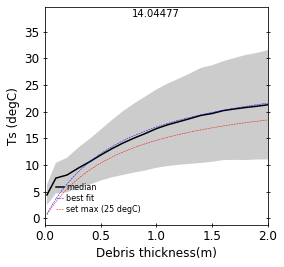

In [29]:
# ===== PLOT AND FIT CURVE (NONLINEAR REGRESSION) =====
## Kraaijenbrink et al. (2017)
##def ts_fromdebris_func(h, hmax, T95):
##    """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
##    Kraaijenbrink et al. (2017) equation"""
##    return 0 + np.log(h*100) / np.log(hmax*100) * (T95 - 0)
##def debris_fromts_func(ts, hmax, T95):
##    """ estimate debris thickness from Ts (b is melt, a and k are coefficients) """
##    return np.exp((ts - 0) / (T95 - 0) * np.log(hmax)) / 100
#def ts_fromdebris_func(h, T95):
#    """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
#    Kraaijenbrink et al. (2017) equation"""
#    return 0 + np.log(h*100) / np.log(1*100) * (T95 - 0)
#def debris_fromts_func(ts, T95):
#    """ estimate debris thickness from Ts (b is melt, a and k are coefficients) """
#    return np.exp((ts - 0) / (T95 - 0) * np.log(1)) / 100
#fit_idx = debris_ts_df_stats.index.values
#func_coeff, pcov = curve_fit(ts_fromdebris_func, 
#                             debris_ts_df_stats.debris_thickness.values[fit_idx], debris_ts_df_stats.ts_degC_med.values[fit_idx],
##                             p0=[30,0.3]
#                             )
#fit_melt = ts_fromdebris_func(debris_ts_df_stats.debris_thickness.values, func_coeff[0])
#debris_4curve = np.arange(0.01,5.01,0.01)
#ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0])
#ts_4curve_setmax = ts_fromdebris_func(debris_4curve, func_coeff[0])
#label_4tscurve = 'Kra2017'
#figure_fn = 'debris_Ts_curve_Kra2017.png'

#def ts_fromdebris_func(h, a, k):
#    """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
#    Michaelis-Menten Equation from single-substrate reactions"""
#    return a - a*np.exp(-k*h)
def ts_fromdebris_func(h, a, k):
    """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
    hyperbolic fit"""
    return a * h / (k + h)
def debris_fromts_func(ts, a, k):
    """ estimate debris thickness from Ts (b is melt, a and k are coefficients) """
    return k * ts / (a - ts)

#fit_idx = debris_ts_df_stats.index.values
# fit_idx = [2,4,7,8,9,10,11,12,13,14]
# print('\nFIT ONLY TO DEBRIS THICKNESSES:', debris_ts_df_stats.debris_thickness.values[fit_idx], 
#       '\nTO ENSURE CAPTURES CURVE \n(plot with equal spacing to avoid this issue, but computationally expensive)')
func_coeff, pcov = curve_fit(ts_fromdebris_func, 
                             debris_ts_df_stats.debris_thickness.values[fit_idx], debris_ts_df_stats.ts_degC_med.values[fit_idx],
#                             p0=[30,0.3]
                             )
fit_melt = ts_fromdebris_func(debris_ts_df_stats.debris_thickness.values, func_coeff[0], func_coeff[1])
debris_4curve = np.arange(0.02,5.01,0.01)
ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1])
ts_max = 25
ts_4curve_setmax = ts_fromdebris_func(debris_4curve, ts_max, func_coeff[1])
label_4tscurve = 'set max ('+ str(ts_max) + ' degC)'

if len(np.where(ts_4curve < 0)[0]) > 0:
    print('\nNEGATIVE FIT!\n')

figure_fn = 'debris_Ts_curve_avg_hyperbolic.png'

# plot curve
fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
#ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_mean'], '-', zorder=1, label='mean')
ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
             '-', color='k', zorder=1, label='median')
ax[0,0].fill_between(debris_ts_df_stats['debris_thickness'], 
                     debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
                     debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
                      facecolor='k', alpha=0.2, zorder=1)
ax[0,0].plot(debris_4curve, ts_4curve, 
             color='b', linewidth=0.5, linestyle='--', zorder=2, label='best fit')
ax[0,0].plot(debris_4curve, ts_4curve_setmax, 
             color='r', linewidth=0.5, linestyle='--', zorder=2, label=label_4tscurve)
# text
ax[0,0].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
             transform=ax[0,0].transAxes)
#eqn_text = r'$T_{s} = \frac{T_{s,max} h}{k + h}$'
#coeff1_text = r'$T_{s,max} = ' + str(np.round(func_coeff[0],2)) + '$' 
#coeff2_text = r'$k = ' + str(np.round(func_coeff[1],2)) + '$' 
## coeff$\frac{b_{0}}{1 + 2kb_{0}h}$'
#ax[0,0].text(0.05, 0.9, eqn_text, size=12, horizontalalignment='left', verticalalignment='top', 
#             transform=ax[0,0].transAxes)
#ax[0,0].text(0.06, 0.79, 'where', size=10, horizontalalignment='left', verticalalignment='top', 
#             transform=ax[0,0].transAxes)
#ax[0,0].text(0.09, 0.74, coeff1_text, size=10, horizontalalignment='left', verticalalignment='top', 
#             transform=ax[0,0].transAxes)
#ax[0,0].text(0.09, 0.67, coeff2_text, size=10, horizontalalignment='left', verticalalignment='top', 
#             transform=ax[0,0].transAxes)
# X-label
ax[0,0].set_xlabel('Debris thickness(m)', size=12)
ax[0,0].set_xlim(0, 2)
#ax[0,0].set_xlim(0, debris_melt_df.debris_thickness.max())
ax[0,0].xaxis.set_tick_params(labelsize=12)
#ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
# Y-label
ax[0,0].set_ylabel('Ts (degC)', size=12)
#ax[0,0].set_ylim(0,(int(debris_ts_df.melt_mwea.values.max()/0.1)+3)*0.1)
#ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(10))
#ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(2))
# Tick parameters
ax[0,0].yaxis.set_ticks_position('both')
ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# Legend
ax[0,0].legend(loc=(0.05, 0.05), 
               fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
               frameon=False)          
# Save plot
fig.set_size_inches(4, 4)
fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300)  

In [30]:
# #%% ===== THE "HILL" EQUATION FITS NGOZUMPA NICELY ======
# def ts_fromdebris_func(h, a, b, c):
#     """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
#     Hill Equation"""
#     return a * h**c / (b**c + h**c)
# def debris_fromts_func_hill(ts, a, b, c):
#     """ estimate debris thickness from surface temperature (ts is surface temperature, a and k are coefficients) 
#     Hill Equation"""
#     return (ts * b**c / (a - ts))**(1/c)

# #fit_idx = debris_ts_df_stats.index.values
# #fit_idx = [1,4,7,8,9,10,12]
# # fit_idx = [2,4,7,8,9,10,11,12,13,14]
# print('\nFIT ONLY TO DEBRIS THICKNESSES:', debris_ts_df_stats.debris_thickness.values[fit_idx], 
#       '\nTO ENSURE CAPTURES CURVE \n(plot with equal spacing to avoid this issue, but computationally expensive)')
# func_coeff, pcov = curve_fit(ts_fromdebris_func, 
#                              debris_ts_df_stats.debris_thickness.values[fit_idx], debris_ts_df_stats.ts_degC_med.values[fit_idx],
#                              p0=[25,1,1]
#                              )
# fit_melt = ts_fromdebris_func(debris_ts_df_stats.debris_thickness.values, func_coeff[0], func_coeff[1], func_coeff[2])
# debris_4curve = np.arange(0.02,5.01,0.01)
# ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1], func_coeff[2])
# ts_max = 30
# ts_4curve_setmax = ts_fromdebris_func(debris_4curve, ts_max, func_coeff[1], func_coeff[2])
# label_4tscurve = 'set max ('+ str(ts_max) + ' degC)'

# if len(np.where(ts_4curve < 0)[0]) > 0:
#     print('\nNEGATIVE FIT!\n')

# figure_fn = 'debris_Ts_curve_avg_Hill.png'

# # plot curve
# fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
# #ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_mean'], '-', zorder=1, label='mean')
# ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
#              '-', color='k', zorder=1, label='median')
# ax[0,0].fill_between(debris_ts_df_stats['debris_thickness'], 
#                      debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
#                      debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
#                       facecolor='k', alpha=0.2, zorder=1)
# ax[0,0].plot(debris_4curve, ts_4curve, 
#              color='b', linewidth=0.5, linestyle='--', zorder=2, label='best fit')
# ax[0,0].plot(debris_4curve, ts_4curve_setmax, 
#              color='r', linewidth=0.5, linestyle='--', zorder=2, label=label_4tscurve)
# # text
# ax[0,0].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
#              transform=ax[0,0].transAxes)
# #eqn_text = r'$T_{s} = \frac{T_{s,max} h^}{k + h}$'
# #coeff1_text = r'$T_{s,max} = ' + str(np.round(func_coeff[0],2)) + '$' 
# #coeff2_text = r'$k = ' + str(np.round(func_coeff[1],2)) + '$' 
# # coeff$\frac{b_{0}}{1 + 2kb_{0}h}$'
# #ax[0,0].text(0.05, 0.9, eqn_text, size=12, horizontalalignment='left', verticalalignment='top', 
# #             transform=ax[0,0].transAxes)
# #ax[0,0].text(0.06, 0.79, 'where', size=10, horizontalalignment='left', verticalalignment='top', 
# #             transform=ax[0,0].transAxes)
# #ax[0,0].text(0.09, 0.74, coeff1_text, size=10, horizontalalignment='left', verticalalignment='top', 
# #             transform=ax[0,0].transAxes)
# #ax[0,0].text(0.09, 0.67, coeff2_text, size=10, horizontalalignment='left', verticalalignment='top', 
# #             transform=ax[0,0].transAxes)
# # X-label
# ax[0,0].set_xlabel('Debris thickness(m)', size=12)
# ax[0,0].set_xlim(0, 2)
# #ax[0,0].set_xlim(0, debris_melt_df.debris_thickness.max())
# ax[0,0].xaxis.set_tick_params(labelsize=12)
# #ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(0.5))
# #ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
# # Y-label
# ax[0,0].set_ylabel('Ts (degC)', size=12)
# #ax[0,0].set_ylim(0,(int(debris_ts_df.melt_mwea.values.max()/0.1)+3)*0.1)
# #ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(10))
# #ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(2))
# # Tick parameters
# ax[0,0].yaxis.set_ticks_position('both')
# ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
# ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# # Legend
# ax[0,0].legend(loc=(0.05, 0.05), 
#                fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
#                frameon=False)          
# # Save plot
# fig.set_size_inches(4, 4)
# fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300)  
# print('hill coeffs:', func_coeff)

# hill_func_coeff = func_coeff.copy()

In [31]:
print('\n\n===== PROCESS SURFACE TEMPERATURE DATA =====\n\n')



===== PROCESS SURFACE TEMPERATURE DATA =====




In [32]:
# # ====== BIN DEBRIS THICKNESS FROM THERMAL METHOD ======
# fn_dict_ts = OrderedDict()
# fn_dict_ts['z1'] = z1_fn
# fn_dict_ts['ts'] = ts_fullfn

# #Expand extent to include buffered region around glacier polygon
# warp_extent = geolib.pad_extent(gf.glac_geom_extent, width=buff_dist)

# #Warp everything to common res/extent/proj
# ds_list_ts = warplib.memwarp_multi_fn(fn_dict_ts.values(), res='min', \
#              extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
#              r='cubic')
# ds_dict_ts = dict(zip(fn_dict_ts.keys(), ds_list_ts))
# ds_list_masked_ts = [iolib.ds_getma(i) for i in ds_list_ts]
# # gf.ts = np.ma.array(iolib.ds_getma(ds_dict_ts['ts']), mask=glac_geom_mask)
# print('\n\n\nPROBLEM WITH BALTORO!!!\n\n\n')
# gf.ts = np.ma.array(iolib.ds_getma(ds_dict_ts['ts']))
# # gf.ts.mask = glac_geom_mask
# print(gf.ts.shape)
    
# if verbose:
#     print("Expanding extent")
#     print(gf.glac_geom_extent)
#     print(warp_extent)
#     print(aea_srs)
    
#     print(ds_list_ts)
#     print(fn_dict_ts.keys())

#     print('list of datasets:', len(ds_list_masked_ts), fn_dict_ts.values())
    
    

In [33]:
# print('max Ts (degC):', np.round(gf.ts.max(),1))
# print('hill_coeff (a,b,c):', hill_func_coeff)

In [34]:
# # ===== ESTIMATE DEBRIS THICKNESS =====
# #Now apply glacier mask AND mask NaN values
# # # glac_geom_mask = np.ma.mask_or(glac_geom_mask, dems_mask)
# # # gf.debris_thick = np.ma.array(iolib.ds_getma(ds_dict['ts']), mask=glac_geom_mask)
# # k = 0.13
# # Tsmax_offset = 6
# # Tsmax = gf.ts.max() + Tsmax_offset
# # gf.debris_thick = gf.ts * 0.13 / (Tsmax - gf.ts)

# Tsmax_offset = 0
# Tsmax = gf.ts.max() + Tsmax_offset
# gf.debris_thick = debris_fromts_func_hill(gf.ts, hill_func_coeff[0], hill_func_coeff[1], hill_func_coeff[2])

# # gf.debris_thick = np.ma.array(gf.debris_thick, mask=glac_geom_mask)
# # gf.debris_thick  = np.ma.masked_less_equal(gf.debris, 0)
# # gf.debris_thick[gf.debris_thick>1] = 1

# gf.res = geolib.get_res(ds_dict['z1'])

# titles = ['Debris thickness (m)']
# clim = malib.calcperc(gf.debris_thick, (2,98))
# plot_array(gf.debris_thick, clim, titles, 'inferno', 'Debris thickness (m)', fn='../debris_thickness.png')

In [35]:
gf.ts.max()

18.205347845597224

In [36]:
#RGI uses 50 m bins
def hist_plot_wdebris(gf, outdir, bin_width=50.0):

    z_bin_edges, z_bin_centers = malib.get_bins(gf.z1, bin_width)
    #Need to compress here, otherwise histogram uses masked values!
    z1_bin_counts, z1_bin_edges = np.histogram(gf.z1.compressed(), bins=z_bin_edges)
    z1_bin_areas = z1_bin_counts * gf.res[0] * gf.res[1] / 1E6
    #RGI standard is integer thousandths of glaciers total area
    #Should check to make sure sum of bin areas equals total area
    z1_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)
    
    #Create arrays to store output
    slope_bin_med = np.ma.masked_all_like(z1_bin_areas)
    slope_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_med = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.dhdt is not None:
        mb_bin_med = np.ma.masked_all_like(z1_bin_areas)
        np.ma.set_fill_value(mb_bin_med, np.nan)
        mb_bin_mad = np.ma.masked_all_like(mb_bin_med)
        mb_bin_mean = np.ma.masked_all_like(mb_bin_med)
        mb_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_med = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mad = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mean = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_count = np.ma.masked_all_like(mb_bin_med)

    if gf.debris_thick is not None:
        debris_thick_med = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_mad = np.ma.masked_all_like(z1_bin_areas)
    else:
        print('NO DEBRIS THICKNESS!')
        
    #Bin sample count must be greater than this value
    min_bin_samp_count = 9

    
    #Loop through each bin and extract stats
    idx = np.digitize(gf.z1, z_bin_edges)
    for bin_n in range(z_bin_centers.size):
        if gf.dhdt is not None:
            mb_bin_samp = gf.mb_map[(idx == bin_n+1)]
            if mb_bin_samp.count() > min_bin_samp_count:
                mb_bin_med[bin_n] = malib.fast_median(mb_bin_samp)
                mb_bin_mad[bin_n] = malib.mad(mb_bin_samp)
                mb_bin_mean[bin_n] = mb_bin_samp.mean()
                mb_bin_std[bin_n] = mb_bin_samp.std()
            dhdt_bin_samp = gf.dhdt[(idx == bin_n+1)]
            if dhdt_bin_samp.count() > min_bin_samp_count:
                dhdt_bin_med[bin_n] = malib.fast_median(dhdt_bin_samp)
                dhdt_bin_mad[bin_n] = malib.mad(dhdt_bin_samp)
                dhdt_bin_mean[bin_n] = dhdt_bin_samp.mean()
                dhdt_bin_std[bin_n] = dhdt_bin_samp.std()
                dhdt_bin_count[bin_n] = dhdt_bin_samp.count()
                
        if gf.debris_thick is not None:
            debris_thick_bin_samp = gf.debris_thick[(idx == bin_n+1)]
            if debris_thick_bin_samp.size > min_bin_samp_count:
                debris_thick_med[bin_n] = malib.fast_median(debris_thick_bin_samp)
                debris_thick_mad[bin_n] = malib.mad(debris_thick_bin_samp)

    if gf.dhdt is not None:
        dhdt_bin_areas = dhdt_bin_count * gf.res[0] * gf.res[1] / 1E6
        #dhdt_bin_areas_perc = 100. * dhdt_bin_areas / np.sum(dhdt_bin_areas)
        dhdt_bin_areas_perc = 100. * (dhdt_bin_areas / gf.glac_area_km2)
                
                
    outbins_header = 'bin_center_elev_m,z1_bin_count_valid,z1_bin_area_valid_km2,z1_bin_area_perc'
    fmt = '%0.1f,%0.0f,%0.3f,%0.2f'
    outbins = [z_bin_centers, z1_bin_counts, z1_bin_areas, z1_bin_areas_perc]
    if gf.dhdt is not None:
        outbins_header += ',dhdt_bin_count,dhdt_bin_area_valid_km2,dhdt_bin_area_perc,dhdt_bin_med_ma,dhdt_bin_mad_ma,dhdt_bin_mean_ma,dhdt_bin_std_ma,mb_bin_med_mwea,mb_bin_mad_mwea,mb_bin_mean_mwea,mb_bin_std_mwea'
        fmt += ', %0.0f,%0.3f,%0.2f,%0.2f,%0.2f,%0.2f,%0.2f,%0.2f,%0.2f,%0.2f,%0.2f'
        outbins.extend([dhdt_bin_count, dhdt_bin_areas, dhdt_bin_areas_perc, dhdt_bin_med, dhdt_bin_mad, dhdt_bin_mean, dhdt_bin_std, \
                        mb_bin_med, mb_bin_mad, mb_bin_mean, mb_bin_std])


#     outbins_header = 'bin_center_elev_m,z1_bin_count_valid,z1_bin_area_valid_km2,z1_bin_area_perc'
#     fmt = '%0.1f,%0.0f,%0.3f,%0.2f'
#     outbins = [z_bin_centers, z1_bin_counts, z1_bin_areas, z1_bin_areas_perc]
    if gf.debris_thick is not None:
        outbins_header += ',debris_thick_med_m,debris_thick_mad_m'
        fmt += ',%0.2f,%0.2f'
        debris_thick_med[debris_thick_med == -(np.inf)] = 0.00
        debris_thick_mad[debris_thick_mad == -(np.inf)] = 0.00
        outbins.extend([debris_thick_med, debris_thick_mad])

    outbins = np.ma.array(outbins).T.astype('float32')
    np.ma.set_fill_value(outbins, np.nan)
    outbins = outbins.filled(np.nan)
    outbins_fn = os.path.join(outdir, gf.feat_fn+'_mb_bins_wdebris.csv')
    np.savetxt(outbins_fn, outbins, fmt=fmt, delimiter=',', header=outbins_header)
    outbins_df = pd.DataFrame(outbins, columns=outbins_header.split(','))
    return outbins_df, z_bin_edges

# outbins_df, z_bin_edges = hist_plot_wdebris(gf, outdir_csv, bin_width=bin_width)
# print(bin_width,z_bin_edges[0:10])

In [37]:
# outbins_df['debris*area'] = outbins_df['debris_thick_med_m'] * outbins_df['z1_bin_area_valid_km2']
# outbins_df['debris*area_mad'] = outbins_df['debris_thick_mad_m'] * outbins_df['z1_bin_area_valid_km2']
# mb_df['debris_thickness_fromTs'] = np.nan
# mb_df['debris_thickness_fromTs_mad'] = np.nan
# for x in mb_df.index.values:
#     if ~np.isnan(mb_df.loc[x,'em_idx_low']):
#         mb_df.loc[x,'debris_thickness_fromTs'] = (
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
#         mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())

# print(mb_df.loc[debris_idx,['# bin_center_elev_m', ' vm_med', ' H_mean',
#        'debris_thickness', 'debris_thickness_1stdlow', 'debris_thickness_1stdhigh', 'debris_thickness_fromTs', 'debris_thickness_fromTs_mad']])

In [38]:
# ===== OPTIMIZE TS_MAX BASED ON THE SUBDEBRIS MELT INVERSION METHOD ======
# from scipy.optimize import minimize

# def objective(Ts_max):
#     """
#     Objective function to fit Ts_max for the surface temperature inversions to the subdebris melt inversions

#     Parameters
#     ----------
#     Ts_max : np.float64
#         Maximum surface temperature for Hill equation

#     Returns
#     -------
#     debris_dif
#         Returns the difference in debris thickness for the subdebris and surface temp inversions
#     """
    
#     # Debris thickness from Hill Equation
#     gf.debris_thick = debris_fromts_func_hill(gf.ts, Ts_max, hill_func_coeff[1], hill_func_coeff[2])
    
#     # Bin debris thicknesses
#     outbins_df, z_bin_edges = hist_plot_wdebris(gf, outdir_csv, bin_width=bin_width)
    
#     outbins_df['debris*area'] = outbins_df['debris_thick_med_m'] * outbins_df['z1_bin_area_valid_km2']
#     outbins_df['debris*area_mad'] = outbins_df['debris_thick_mad_m'] * outbins_df['z1_bin_area_valid_km2']
#     mb_df['debris_thickness_fromTs'] = np.nan
#     mb_df['debris_thickness_fromTs_mad'] = np.nan
#     for x in mb_df.index.values:
#         if ~np.isnan(mb_df.loc[x,'em_idx_low']):
#             mb_df.loc[x,'debris_thickness_fromTs'] = (
#                     outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
#                     outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
#             mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
#                     outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
#                     outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
    
#     # Compare only over bins with low velocity and lots of debris
#     vel_lt10_idx_raw = np.where((mb_df[' vm_med'] < 7.5) & (mb_df[' perc_debris'] > 50))[0]
#     # only work with terminus
#     vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
#     idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
#     vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]

#     debris_dif_sum = (mb_df.loc[vel_lt10_idx, 'debris_thickness_fromTs'] - mb_df.loc[vel_lt10_idx,'debris_thickness']).sum()
    
#     debris_dif_sum_abs = abs(debris_dif_sum)

#     return debris_dif_sum_abs


# ts_max_obj = minimize(objective, hill_func_coeff[0], method='SLSQP',
#                       options={'ftol':1e-3, 'eps':0.1}
#                      )
# ts_max_opt = ts_max_obj.x[0]

# print(ts_max_opt)

In [39]:
# ===== OUTPUT FINAL DEBRIS THICKNESS =====
# gf.debris_thick = debris_fromts_func_hill(gf.ts, ts_max_opt, hill_func_coeff[1], hill_func_coeff[2])

# # gf.debris_thick = np.ma.array(gf.debris_thick, mask=glac_geom_mask)
# # gf.debris_thick  = np.ma.masked_less_equal(gf.debris, 0)
# # gf.debris_thick[gf.debris_thick>1] = 1

# gf.res = geolib.get_res(ds_dict['z1'])

# titles = ['Debris thickness (m)']
# clim = malib.calcperc(gf.debris_thick, (2,98))
# plot_array(gf.debris_thick, clim, titles, 'inferno', 'Debris thickness (m)', fn='../debris_thickness.png')

In [40]:
# # Plot optimized curve
# debris_4curve = np.arange(0.02,5.01,0.01)
# ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1], func_coeff[2])

# figure_fn = 'debris_Ts_curve_Hill_optimized.png'

# # plot curve
# fig, ax = plt.subplots(1, 2, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
# #ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_mean'], '-', zorder=1, label='mean')
# ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
#              '-', color='k', zorder=1, label='median')
# ax[0,0].fill_between(debris_ts_df_stats['debris_thickness'], 
#                      debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
#                      debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
#                      facecolor='k', alpha=0.2, zorder=1)
# ax[0,0].plot(debris_4curve, ts_4curve, 
#              color='b', linewidth=0.5, linestyle='--', zorder=2, label='optimized')
# # text
# ax[0,0].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
#              transform=ax[0,0].transAxes)
# # X-label
# ax[0,0].set_xlabel('Debris thickness(m)', size=12)
# ax[0,0].set_xlim(0, 2)
# ax[0,0].xaxis.set_tick_params(labelsize=12)
# # Y-label
# ax[0,0].set_ylabel('Ts (degC)', size=12)
# # Tick parameters
# ax[0,0].yaxis.set_ticks_position('both')
# ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
# ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# # Legend
# ax[0,0].legend(loc=(0.05, 0.05), 
#                fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
#                frameon=False)    

# ax[0,1].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
#              '-', color='k', zorder=1, label='median')
# ax[0,1].fill_between(debris_ts_df_stats['debris_thickness'], 
#                      debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
#                      debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
#                      facecolor='k', alpha=0.2, zorder=1)
# ax[0,1].plot(debris_4curve, ts_4curve, 
#              color='b', linewidth=0.5, linestyle='--', zorder=2, label='optimized')
# # text
# ax[0,1].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
#              transform=ax[0,0].transAxes)
# # X-label
# ax[0,1].set_xlabel('Debris thickness(m)', size=12)
# ax[0,1].set_xlim(0, 0.25)
# ax[0,1].xaxis.set_tick_params(labelsize=12)
# # Y-label
# ax[0,1].set_ylabel('Ts (degC)', size=12)
# # Tick parameters
# ax[0,1].yaxis.set_ticks_position('both')
# ax[0,1].tick_params(axis='both', which='major', labelsize=12, direction='inout')
# ax[0,1].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# # Legend
# ax[0,1].legend(loc=(0.05, 0.05), 
#                fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
#                frameon=False)    

# # Save plot
# fig.set_size_inches(6, 4)
# fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300)  

In [41]:
# # Export binned file
# outbins_df, z_bin_edges = hist_plot_wdebris(gf, outdir_csv, bin_width=bin_width)
# outbins_df['debris*area'] = outbins_df['debris_thick_med_m'] * outbins_df['z1_bin_area_valid_km2']
# outbins_df['debris*area_mad'] = outbins_df['debris_thick_mad_m'] * outbins_df['z1_bin_area_valid_km2']
# mb_df['debris_thickness_fromTs'] = np.nan
# mb_df['debris_thickness_fromTs_mad'] = np.nan
# for x in mb_df.index.values:
#     if ~np.isnan(mb_df.loc[x,'em_idx_low']):
#         mb_df.loc[x,'debris_thickness_fromTs'] = (
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
#         mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
# mb_df.to_csv(outdir_csv + '/' + glac_str + '_mb_bins_wdebris_inversions_Hill.csv', index=False)

In [42]:
# ========== EQUATIONS EITHER MISS THE THIN DEBRIS OR THE THICK DEBRIS ==========
print('\n\nEQUATIONS MISS THIN OR THICK DEBRIS SO USE THE RAW DATA\n\n')



EQUATIONS MISS THIN OR THICK DEBRIS SO USE THE RAW DATA




In [43]:
debris_ts_df_stats

,debris_thickness,ts_degC_mean,ts_degC_std,ts_degC_med,ts_degC_nmad
0,0.02,5.305988,2.314892,4.379685,1.908266
1,0.10,11.279792,6.424161,7.541590,2.864700
2,0.20,11.485513,6.409052,8.122289,3.240148
3,0.30,12.430781,6.589066,9.403244,3.813562
4,0.40,13.656795,6.793347,10.571342,4.277811
5,0.50,14.795959,6.920981,11.839756,4.763569
6,0.60,15.853619,7.035866,13.032728,5.363250
7,0.70,16.847651,7.164995,14.101457,5.970608
8,0.80,17.779595,7.315154,15.038741,6.466660
9,0.90,18.651017,7.486132,15.889644,6.931100


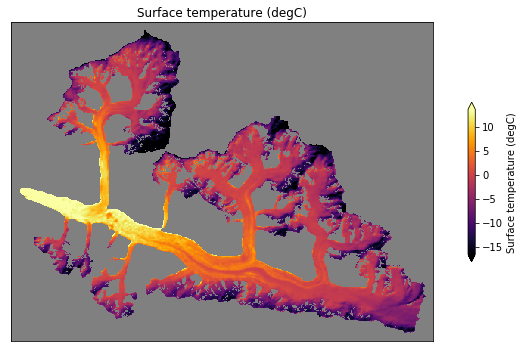

In [44]:
#Now apply glacier mask AND mask NaN values
# gf.ts = np.ma.array(iolib.ds_getma(ds_dict_ts['ts']), mask=glac_geom_mask)
# # glac_geom_mask = np.ma.mask_or(glac_geom_mask, dems_mask)
# gf.ts = np.ma.array(gf.ts, mask=glac_geom_mask)
# # gf.debris_thick  = np.ma.masked_less_equal(gf.debris, 0)
# # gf.debris_thick[gf.debris_thick>1] = 1

gf.res = geolib.get_res(ds_dict['z1'])

titles = ['Surface temperature (degC)']
clim = malib.calcperc(gf.ts, (2,98))
plot_array(gf.ts, clim, titles, 'inferno', 'Surface temperature (degC)', fn='../ts.png')

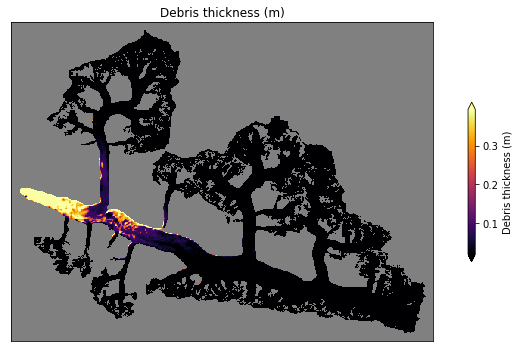

In [45]:
# Surface temperature dictionary
def ts_dict(debris_ts_df_stat, ts_offset=0):
    debris_ts_df_stats_adj = debris_ts_df_stats.copy()
    debris_ts_df_stats_adj['ts_degC_mean'] = debris_ts_df_stats_adj['ts_degC_mean'] + ts_offset
    debris_ts_df_stats_adj['ts_degC_med'] = debris_ts_df_stats_adj['ts_degC_med'] + ts_offset
    ts_str_subset = np.array([str(np.round(x,2)) for x in debris_ts_df_stats_adj.ts_degC_mean.values])
    ts_dict = dict(zip(ts_str_subset, debris_ts_df_stats_adj['debris_thickness']))
    ts_step = 0.01
    ts = np.arange(np.round(debris_ts_df_stats_adj['ts_degC_mean'].min(),2), 
                  np.round(debris_ts_df_stats_adj['ts_degC_mean'].max(),2), ts_step)
    ts_str = np.array([str(np.round(x,2)) for x in ts])
    ds_ts_filled = pd.DataFrame(np.zeros((ts_str.shape[0], 3)), columns=['ts', 'ts_str', 'thickness'])
    ds_ts_filled['ts'] = ts
    ds_ts_filled['ts_str'] = ts_str
    ds_ts_filled['thickness'] = ds_ts_filled.ts_str.map(ts_dict)
    ds_ts_filled = ds_ts_filled.interpolate(method='linear', axis=0)
    ts_dict_filled = dict(zip(ds_ts_filled.ts_str, ds_ts_filled.thickness))
    ts_dict_filled['nan'] = 0
#     print(ts_dict_filled)
    return ds_ts_filled, ts_dict_filled

def ts_to_debristhickness_fromdata(ts, debris_ts_df_stats, ts_offset=0):
    # Create dictionary
    ds_ts_filled, ts_dict_filled = ts_dict(debris_ts_df_stats, ts_offset=ts_offset)
    # Use dictionary to map thickness values
    gf.debris_thick = ts.copy()
    gf.debris_thick[gf.ts > ds_ts_filled.ts.max()] = ds_ts_filled.ts.max()
    gf.debris_thick[gf.ts < ds_ts_filled.ts.min()] = ds_ts_filled.ts.min()
    # Round to nearest 0.01 deg and convert to string for dictionary
    gf.debris_thick = np.round(gf.debris_thick,2)
    gf.debris_thick = gf.debris_thick.astype(str)
    # Convert to thickness
    for key in ts_dict_filled:
        gf.debris_thick[gf.debris_thick == key] = ts_dict_filled[key]
    gf.debris_thick = gf.debris_thick.astype(float)
    return gf.debris_thick

# process
# Estimate initial guess based on setting max to 2 m
# ts_clim = malib.calcperc(gf.ts, (2,98))
# debris_2m_idx = np.where(debris_ts_df_stats.debris_thickness == 2)[0][0]
# ts_offset_init = ts_clim[1] - debris_ts_df_stats.loc[debris_2m_idx,'ts_degC_mean']
# print(ts_clim[1], debris_ts_df_stats.loc[debris_2m_idx,'ts_degC_mean'], ts_offset_init)
# ts_offset_init = ts_clim[1] - debris_ts_df_stats.ts_degC_mean.max()
# print(ts_clim[1], debris_ts_df_stats.ts_degC_mean.max(), ts_offset_init)
# ts_offset_init = ts_clim[0] - debris_ts_df_stats.ts_degC_mean.min()
# print(ts_clim[0], debris_ts_df_stats.ts_degC_mean.max(), ts_offset_init)
ts_offset_init = 0

gf.debris_thick = ts_to_debristhickness_fromdata(gf.ts, debris_ts_df_stats, ts_offset=ts_offset_init)
gf.debris_thick = np.ma.array(gf.debris_thick, mask=glac_geom_mask)
# gf.debris_thick  = np.ma.masked_less_equal(gf.debris, 0)
# gf.debris_thick[gf.debris_thick>1] = 1

gf.res = geolib.get_res(ds_dict['z1'])

titles = ['Debris thickness (m)']
clim = malib.calcperc(gf.debris_thick, (2,98))
plot_array(gf.debris_thick, clim, titles, 'inferno', 'Debris thickness (m)', fn='../debris_thickness.png')

# Export binned file
outbins_df, z_bin_edges = hist_plot_wdebris(gf, outdir_csv, bin_width=bin_width)
outbins_df['debris*area'] = outbins_df['debris_thick_med_m'] * outbins_df['z1_bin_area_valid_km2']
outbins_df['debris*area_mad'] = outbins_df['debris_thick_mad_m'] * outbins_df['z1_bin_area_valid_km2']
mb_df['debris_thickness_fromTs'] = np.nan
mb_df['debris_thickness_fromTs_mad'] = np.nan
for x in mb_df.index.values:
    if ~np.isnan(mb_df.loc[x,'em_idx_low']):
        mb_df.loc[x,'debris_thickness_fromTs'] = (
                outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
                outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
        mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
                outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
                outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
mb_df.to_csv(outdir_csv + '/' + gf.feat_fn + '_mb_bins_wdebris_inversions_fromdata_notopt.csv', index=False)

In [46]:
# ===== OPTIMIZE TS_MAX BASED ON THE SUBDEBRIS MELT INVERSION METHOD ======
from scipy.optimize import minimize

def objective(Ts_offset):
    """
    Objective function to fit Ts_offset for the surface temperature inversions to the subdebris melt inversions

    Parameters
    ----------
    Ts_offset : np.float64
        Temperature offset used to shift data/curve up or down

    Returns
    -------
    debris_dif
        Returns the difference in debris thickness for the subdebris and surface temp inversions
    """
    
    # Debris thickness from Hill Equation
    gf.debris_thick = ts_to_debristhickness_fromdata(gf.ts, debris_ts_df_stats, ts_offset=Ts_offset)
    gf.debris_thick = np.ma.array(gf.debris_thick, mask=glac_geom_mask)
    
    # Bin debris thicknesses
    outbins_df, z_bin_edges = hist_plot_wdebris(gf, outdir_csv, bin_width=bin_width)
    
    outbins_df['debris*area'] = outbins_df['debris_thick_med_m'] * outbins_df['z1_bin_area_valid_km2']
    outbins_df['debris*area_mad'] = outbins_df['debris_thick_mad_m'] * outbins_df['z1_bin_area_valid_km2']
    mb_df['debris_thickness_fromTs'] = np.nan
    mb_df['debris_thickness_fromTs_mad'] = np.nan
    for x in mb_df.index.values:
        if ~np.isnan(mb_df.loc[x,'em_idx_low']):
            mb_df.loc[x,'debris_thickness_fromTs'] = (
                    outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
                    outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
            mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
                    outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
                    outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
    
    # Compare only over bins with low velocity and lots of debris
    vel_lt10_idx_raw = np.where((mb_df[' vm_med'] < 7.5) & (mb_df[' perc_debris'] > 50))[0]
    # only work with terminus
    vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
    if np.sum(vel_idx_dif) == len(vel_lt10_idx_raw)-1:
        vel_lt10_idx = vel_lt10_idx_raw
    else:
        idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
        vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]

    debris_dif_sum = (mb_df.loc[vel_lt10_idx, 'debris_thickness_fromTs'] - mb_df.loc[vel_lt10_idx,'debris_thickness']).sum()
    
    debris_dif_sum_abs = abs(debris_dif_sum)
    
    print(Ts_offset, debris_dif_sum_abs)

    return debris_dif_sum_abs

def run_objective(ts_offset_init):
    """
    Run objective function and return interesting output
    Parameters
    ----------
    Ts_offset : np.float64
        Temperature offset used to shift data/curve up or down

    Returns
    -------
    debris_dif
        Returns the difference in debris thickness for the subdebris and surface temp inversions
    """
    
    ts_offset_obj = minimize(objective, ts_offset_init, method='SLSQP',
                      options={'ftol':1e-3, 'eps':0.1}
                     )
    ts_offset_opt = ts_offset_obj.x[0]
    
    print(ts_offset_opt)
    
    # Debris thickness from Hill Equation
    gf.debris_thick = ts_to_debristhickness_fromdata(gf.ts, debris_ts_df_stats, ts_offset=ts_offset_opt)
    gf.debris_thick = np.ma.array(gf.debris_thick, mask=glac_geom_mask)
    
    # Bin debris thicknesses
    outbins_df, z_bin_edges = hist_plot_wdebris(gf, outdir_csv, bin_width=bin_width)
    
    outbins_df['debris*area'] = outbins_df['debris_thick_med_m'] * outbins_df['z1_bin_area_valid_km2']
    outbins_df['debris*area_mad'] = outbins_df['debris_thick_mad_m'] * outbins_df['z1_bin_area_valid_km2']
    mb_df['debris_thickness_fromTs'] = np.nan
    mb_df['debris_thickness_fromTs_mad'] = np.nan
    for x in mb_df.index.values:
        if ~np.isnan(mb_df.loc[x,'em_idx_low']):
            mb_df.loc[x,'debris_thickness_fromTs'] = (
                    outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
                    outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
            mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
                    outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
                    outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
    
    # Compare only over bins with low velocity and lots of debris
    vel_lt10_idx_raw = np.where((mb_df[' vm_med'] < 7.5) & (mb_df[' perc_debris'] > 50))[0]
    # only work with terminus
    vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
    if np.sum(vel_idx_dif) == len(vel_lt10_idx_raw)-1:
        vel_lt10_idx = vel_lt10_idx_raw
    else:
        idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
        vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]

    debris_dif_sum = (mb_df.loc[vel_lt10_idx, 'debris_thickness_fromTs'] - mb_df.loc[vel_lt10_idx,'debris_thickness']).sum()
    
    debris_dif_sum_abs = abs(debris_dif_sum)

    return mb_df, ts_offset_obj, vel_lt10_idx


def run_objective(ts_offset):
    # Debris thickness from Hill Equation
    gf.debris_thick = ts_to_debristhickness_fromdata(gf.ts, debris_ts_df_stats, ts_offset=ts_offset)
    gf.debris_thick = np.ma.array(gf.debris_thick, mask=glac_geom_mask)
    
    # Bin debris thicknesses
    outbins_df, z_bin_edges = hist_plot_wdebris(gf, outdir_csv, bin_width=bin_width)
    
    outbins_df['debris*area'] = outbins_df['debris_thick_med_m'] * outbins_df['z1_bin_area_valid_km2']
    outbins_df['debris*area_mad'] = outbins_df['debris_thick_mad_m'] * outbins_df['z1_bin_area_valid_km2']
    mb_df['debris_thickness_fromTs'] = np.nan
    mb_df['debris_thickness_fromTs_mad'] = np.nan
    for x in mb_df.index.values:
        if ~np.isnan(mb_df.loc[x,'em_idx_low']):
            mb_df.loc[x,'debris_thickness_fromTs'] = (
                    outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
                    outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
            mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
                    outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
                    outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
    
    # Compare only over bins with low velocity and lots of debris
    vel_lt10_idx_raw = np.where((mb_df[' vm_med'] < 7.5) & (mb_df[' perc_debris'] > 50))[0]
    # only work with terminus
    vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
    if np.sum(vel_idx_dif) == len(vel_lt10_idx_raw)-1:
        vel_lt10_idx = vel_lt10_idx_raw
    else:
        idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
        vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]

    debris_dif_sum = (mb_df.loc[vel_lt10_idx, 'debris_thickness_fromTs'] - mb_df.loc[vel_lt10_idx,'debris_thickness']).sum()
    
    debris_dif_sum_abs = abs(debris_dif_sum)

    return mb_df, ts_offset_obj, vel_lt10_idx

In [47]:
ts_offset_obj = minimize(objective, ts_offset_init, method='SLSQP',
                      options={'ftol':1e-3, 'eps':0.1}
                     )
ts_offset_opt = ts_offset_obj.x[0]

print(ts_offset_opt)

mb_df, ts_offset_obj, vel_lt10_idx = run_objective(ts_offset_opt)

# eps_opt = 0.01
# n = 0
# while n < 5:
#     n += 1 
#     eps_opt = eps_opt*10
#     ts_offset_obj = minimize(objective, 0, method='SLSQP', options={'ftol':1e-3, 'eps':eps_opt})
#     ts_offset_opt = ts_offset_obj.x[0]
#     print('eps_opt:', eps_opt, 'ts_offset_opt:', ts_offset_opt)

mb_df['debris_dif'] =  mb_df['debris_thickness'] - mb_df['debris_thickness_fromTs']
cols2print = ['# bin_center_elev_m', ' mb_bin_mean_mwea', ' debris_thick_med_m', ' perc_debris',
              'debris_thickness', 'debris_thickness_fromTs', 'debris_dif']
print(mb_df.loc[vel_lt10_idx, cols2print])

[0.] 0.6865241629757386
[0.] 0.6865241629757386
[0.1] 0.6675875736155015
[0.18936589] 0.6506086876370412
[0.18936589] 0.6506086876370412
[0.28936589] 0.631872265575121
[1.126187] 0.481838091252039
[1.126187] 0.481838091252039
[1.226187] 0.46434199714441116
[5.50021052] 0.2637551501638788
[5.50021052] 0.2637551501638788
[5.60021052] 0.2664206060826379
[4.92194313] 0.23525899464856564
[4.92194313] 0.23525899464856564
[5.02194313] 0.23893879496153175
[0.93030233] 0.5153854107238751
[4.2354151] 0.16851024797778308
[4.2354151] 0.16851024797778308
[4.3354151] 0.18737072220664203
[-98.05850315] 9.121184325752449
[-30.70020704] 9.121184325752449
[-3.17019952] 1.3530561094858151
[2.23182107] 0.2935460796334249
[3.48268301] 0.05460504346866428
[3.48268301] 0.05460504346866428
[3.58268301] 0.028294562337587467
[3.92112279] 0.07364358569156111
[3.67084778] 0.0041098436095219765
[3.67084778] 0.0041098436095219765
[3.77084778] 0.024341020757665047
[3.5890545] 0.02696231657047092
[3.65367155] 0.00928

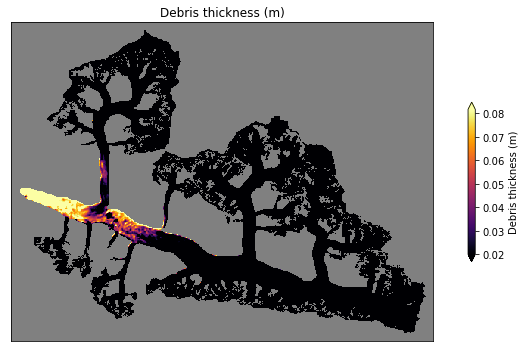

In [48]:
# Plot debris thickness
gf.debris_thick = ts_to_debristhickness_fromdata(gf.ts, debris_ts_df_stats, ts_offset=ts_offset_opt)
gf.debris_thick = np.ma.array(gf.debris_thick, mask=glac_geom_mask)
# gf.debris_thick  = np.ma.masked_less_equal(gf.debris, 0)
# gf.debris_thick[gf.debris_thick>1] = 1

gf.res = geolib.get_res(ds_dict['z1'])

titles = ['Debris thickness (m)']
clim = malib.calcperc(gf.debris_thick, (2,98))
plot_array(gf.debris_thick, clim, titles, 'inferno', 'Debris thickness (m)', fn='../debris_thickness.png')

# Export binned file
mb_df.to_csv(outdir_csv + '/' + gf.feat_fn + '_mb_bins_wdebris_inversions_fromdata.csv', index=False)

In [49]:
# Export debris thickness map
iolib.writeGTiff(gf.debris_thick, debris_fullfn, ds_dict['z1'])